In [1]:
"""
In this demo, we will be training a neural network to 

    1. draw a unit circle
It will take an angle theta as the input, and produce location (x, y) as output.
We will also explore what happens when you apply an NN to inputs that 
are outside of the training space.

and
    2. calculate a Gaussian
given inputs 
    x     (position)
    mu    (mean)
    sigma (standard deviation)

We will train it on x     in [+- 3sigma from mu]
                    mu    in [30  , 50)
                    sigma in [ 0.1, 10)

Note: These are not problems that require a neural network!
      We are using these simple cases to illustrate how to train/use a NN.
"""

import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore FutureWarnings and Depreciation Warnings
import warnings
warnings.simplefilter('ignore', category=Warning)
# Some will still make it through...Tensorflow is annoying

from sklearn import metrics

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Convolution1D, Dense, Input
from keras.losses import mean_squared_error
from keras.optimizers  import adam
import tensorflow as tf
# if you need debug utilities:
#from tensorflow.python import debug as tf_debug

ModuleNotFoundError: No module named 'keras'

In [2]:
def DenseNet(inp_shape, out_shape, learnrate=1e-3, 
             layers=None, activations=None, outactiv=None):
    """
    Builds a dense neural network.

    Inputs
    ------
    inp_shape  : int.   Number of inputs.
    out_shape  : int.   Number of outputs.
    learnrate  : float. Model learning rate.
    layers     : 1D array/list. Number of neurons in each hidden layer.
    activations: 1D array/list. Activation function for each hidden layer.
    outactiv   : string. Activation function for output layer.
                         If None, linear activation.

    Outputs
    -------
    model: Keras model object.

    Examples
    --------
    >>> model = DenseNet(4, 1, learnrate=1e-3)
    >>> print(model.summary())
    Model: "model_1"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 4)                 0         
    _________________________________________________________________
    dense_1 (Dense)              (None, 1)                 5         
    =================================================================
    Total params: 5
    Trainable params: 5
    Non-trainable params: 0
    _________________________________________________________________

    >>> model = DenseNet(4, 1, learnrate=1e-3, layers=[4, 8], 
    ...                  activations=['tanh', 'relu'])
    >>> print(model.summary())
    Model: "model_2"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_2 (InputLayer)         (None, 4)                 0         
    _________________________________________________________________
    dense_2 (Dense)              (None, 4)                 20        
    _________________________________________________________________
    dense_3 (Dense)              (None, 8)                 40        
    _________________________________________________________________
    dense_4 (Dense)              (None, 1)                 9         
    =================================================================
    Total params: 69
    Trainable params: 69
    Non-trainable params: 0
    _________________________________________________________________


    Revisions
    ---------
    2019-11-14  Michael Himes           Initial implementation.
    """
    # Set the input layer
    inp = Input(shape=(inp_shape,))
    x   = inp
    
    # Set the hidden layers
    if layers is not None:
        for i in range(len(layers)):
            x = Dense(layers[i], activation=activations[i])(x)
    
    # Set the output layer
    if outactiv is None:
        out = Dense(out_shape)(x)
    else:
        out = Dense(out_shape, activation=outactiv)(x)
    
    # Build the model
    model = Model(inp, out)
    
    # Compile the model
    model.compile(optimizer=adam(lr=learnrate),
                  loss=mean_squared_error)
    
    return model

In [3]:
def TrainModel(model, 
               inputs_tr_norm,  outputs_tr_norm, 
               inputs_val_norm, outputs_val_norm, 
               batch_size, epochs, patience, 
               fname, load=True):
    """
    Trains a model and plots the loss history.

    Inputs
    ------
    model           : object. Keras model. See DenseNet().
    inputs_tr_norm  : array.  Normalized training inputs.
    outputs_tr_norm : array.  Normalized training outputs.
    inputs_val_norm : array.  Normalized validation inputs.
    outputs_val_norm: array.  Normalized validation outputs.
    batch_size      : int.    Mini-batch size per training iteration.
    epochs          : int.    Max number of epochs for training.
    patience        : int.    Number of epochs to stop training after 
                              if no improvement in loss
    fname           : string. A descriptor of the model, for plot savenames.
    load            : bool.   Sets whether to attempt to load a .h5 weight file.

    Outputs
    -------
    2 plots:
        `fname`_loss.png      : Full training/validation loss history.
        `fname`_loss_zoom.png : Zoomed in view of the end of the loss history.

    Examples
    --------
    # The following must be executed from the NN-gaussian/ directory.
    >>> np.random.seed(0)
    >>> xlo    , xhi     = 30  , 50
    >>> mulo   , muhi    = 39  , 41
    >>> sigmalo, sigmahi =  1  , 10
    >>> nsamp            = int(1e5)
    >>> inputs      = np.zeros((nsamp, 3))
    >>> inputs[:,0] = np.random.uniform(xlo    , xhi    , nsamp)
    >>> inputs[:,1] = np.random.uniform(mulo   , muhi   , nsamp)
    >>> inputs[:,2] = np.random.uniform(sigmalo, sigmahi, nsamp)
    >>> gaus = 1./inputs[:,2]/np.sqrt(2.*np.pi) * \
    ...        np.exp(-(1./2.) * ((inputs[:,0] - inputs[:,1])/inputs[:,2])**2)
    >>> gaus = np.expand_dims(gaus, -1)
    >>> ntr             = int(nsamp * 0.7)
    >>> nval            = int(nsamp * 0.1)
    >>> inputs_tr       = inputs[        :ntr         ]
    >>> inputs_val      = inputs[ntr     :ntr+nval    ]
    >>> gaus_tr         = gaus  [        :ntr         ]
    >>> gaus_val        = gaus  [ntr     :ntr+nval    ]
    >>> inputs_tr_mean  = np.mean(inputs_tr, axis=0)
    >>> inputs_tr_stdev = np.std (inputs_tr, axis=0)
    >>> gaus_tr_mean    = np.mean(gaus_tr, axis=0)
    >>> gaus_tr_stdev   = np.std (gaus_tr, axis=0)
    >>> inputs_tr_norm  = (inputs_tr  - inputs_tr_mean) / inputs_tr_stdev
    >>> inputs_val_norm = (inputs_val - inputs_tr_mean) / inputs_tr_stdev
    >>> gaus_tr_norm    = (gaus_tr  - gaus_tr_mean) / gaus_tr_stdev
    >>> gaus_val_norm   = (gaus_val - gaus_tr_mean) / gaus_tr_stdev
    >>> learnrate       = 1e-3
    >>> model           = DenseNet(inputs.shape[-1], gaus_tr.shape[-1], 
    ...                            learnrate=learnrate)
    >>> patience        = 30
    >>> batch_size      = 1024
    >>> epochs          = 800
    >>> TrainModel(model, 
    ...            inputs_tr_norm,  gaus_tr_norm, 
    ...            inputs_val_norm, gaus_val_norm, 
    ...            batch_size, epochs, patience, 
    ...            'example')

    # This will produce a lot of output, which is not shown here. 
    # The last of the output should be similar to:
    Epoch 61/800
    70000/70000 [==============================] - 0s 2us/step - loss: 0.9815 - val_loss: 0.9235
    
    Epoch 00061: val_loss did not improve from 0.92312
    Epoch 00061: early stopping
    # And 2 plots will be created, example_loss.png, and example_loss_zoom.png
    # in ./plots/

    Revisions
    ---------
    2019-11-14  Michael Himes           Initial implementation.
    2019-11-18  Michael Himes           Updated example.
    """
    ### First, callbacks! These will run during training and do something useful
    ### at the end of each epoch.
    ### For example, the EarlyStopping callback will monitor training and enforce 
    ### early stopping for us
    Early_Stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=patience,
                                               verbose=1, mode='auto')
    ### The ModelCheckpoint callback saves the best-performing model
    weight_file      = 'weights/'+fname+'_checkpoint_weights_mse_loss.h5'
    # Load, if specified
    if load:
        try:
            model.load_weights(weight_file)
            print("Loaded previously-trained model.")
            return
        except:
            print("Weight file does not exist. Training new model.")

    Model_Checkpoint = keras.callbacks.ModelCheckpoint(weight_file, 
                                                       monitor='val_loss',
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       mode='auto', verbose=1)
    history = model.fit(x=inputs_tr_norm, y=outputs_tr_norm, 
                        validation_data=(inputs_val_norm, outputs_val_norm), 
                        batch_size=batch_size, epochs=epochs, 
                        callbacks=[Early_Stop, Model_Checkpoint])
    # Plot the loss history
    tr_loss  = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(tr_loss , label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/'+fname+'_loss.png')
    plt.ylim(np.amin(val_loss)*0.9, np.amin(val_loss)*1.5)
    plt.savefig('plots/'+fname+'_loss_zoom.png')
    plt.show()

In [4]:
def ValidateModel(model, 
                  inputs_val_norm, outputs_val_norm, 
                  outputs_mean, outputs_stdev, 
                  batch_size, fname):
    """
    Validates a model by computing the root mean squared error (RMSE) and R^2 
    for the validation set.

    Inputs
    ------
    model           : object. Keras model. See DenseNet().
    inputs_val_norm : array.  Normalized training inputs.
    outputs_val_norm: array.  Normalized training outputs.
    outputs_mean    : array.  Normalized validation inputs.
    outputs_stdev   : array.  Normalized validation outputs.
    batch_size      : int.    Mini-batch size per training iteration.
    fname           : string. A descriptor of the model, for plot savenames.

    Outputs
    -------
    val_pred: array. Predicted values for validation set.
    rmse_val: array. Normalized RMSE for each output parameter.
    r2_val  : array. R^2 value for each output parameter.
    `fname`_r2_val_param<param#>.png : Plot of predicted vs. true 
                                       for each parameter.
    

    Examples
    --------
    # The following must be executed from the NN-gaussian/ directory.
    >>> np.random.seed(0)
    >>> xlo    , xhi     = 30  , 50
    >>> mulo   , muhi    = 39  , 41
    >>> sigmalo, sigmahi =  1  , 10
    >>> nsamp            = int(1e5)
    >>> inputs      = np.zeros((nsamp, 3))
    >>> inputs[:,0] = np.random.uniform(xlo    , xhi    , nsamp)
    >>> inputs[:,1] = np.random.uniform(mulo   , muhi   , nsamp)
    >>> inputs[:,2] = np.random.uniform(sigmalo, sigmahi, nsamp)
    >>> gaus = 1./inputs[:,2]/np.sqrt(2.*np.pi) * \
    ...        np.exp(-(1./2.) * ((inputs[:,0] - inputs[:,1])/inputs[:,2])**2)
    >>> gaus = np.expand_dims(gaus, -1)
    >>> ntr             = int(nsamp * 0.7)
    >>> nval            = int(nsamp * 0.1)
    >>> inputs_tr       = inputs[        :ntr         ]
    >>> inputs_val      = inputs[ntr     :ntr+nval    ]
    >>> gaus_tr         = gaus  [        :ntr         ]
    >>> gaus_val        = gaus  [ntr     :ntr+nval    ]
    >>> inputs_tr_mean  = np.mean(inputs_tr, axis=0)
    >>> inputs_tr_stdev = np.std (inputs_tr, axis=0)
    >>> gaus_tr_mean    = np.mean(gaus_tr, axis=0)
    >>> gaus_tr_stdev   = np.std (gaus_tr, axis=0)
    >>> inputs_tr_norm  = (inputs_tr  - inputs_tr_mean) / inputs_tr_stdev
    >>> inputs_val_norm = (inputs_val - inputs_tr_mean) / inputs_tr_stdev
    >>> gaus_tr_norm    = (gaus_tr  - gaus_tr_mean) / gaus_tr_stdev
    >>> gaus_val_norm   = (gaus_val - gaus_tr_mean) / gaus_tr_stdev
    >>> learnrate       = 1e-3
    >>> model           = DenseNet(inputs.shape[-1], gaus_tr.shape[-1], 
    ...                            learnrate=learnrate)
    >>> patience        = 30
    >>> batch_size      = 1024
    >>> epochs          = 800
    >>> TrainModel(model, 
    ...            inputs_tr_norm,  gaus_tr_norm, 
    ...            inputs_val_norm, gaus_val_norm, 
    ...            batch_size, epochs, patience, 
    ...            'example')

    # This will produce a lot of output, which is not shown here. 
    # The last of the output should be similar to:
    Epoch 61/800
    70000/70000 [==============================] - 0s 2us/step - loss: 0.9815 - val_loss: 0.9235
    
    Epoch 00061: val_loss did not improve from 0.92312
    Epoch 00061: early stopping
    # And 2 plots will be created, example_loss.png, and example_loss_zoom.png
    # in ./plots/
    # Now, validate
    val_pred_denorm, rmse_val, r2_val = ValidateModel(model, 
                                                      inputs_val_norm, 
                                                      gaus_val_norm, 
                                                      gaus_tr_mean, 
                                                      gaus_tr_stdev, 
                                                      batch_size, 
                                                      'example')
    Normalized RMSE: [0.96093928]
    R2: [0.01351501]
    # And 1 plot is created, example_r2_val_param0.png in ./plots/

    Revisions
    ---------
    2019-11-14  Michael Himes           Initial implementation.
    2019-11-18  Michael Himes           Updated example.
    """
    # Array to hold predictions
    val_pred = np.zeros(outputs_val_norm.shape)
    # Make predictions
    for batch in range(0, int(np.ceil(outputs_val_norm.shape[0]/batch_size))):
        val_batch = inputs_val_norm[batch*batch_size : (batch+1)*batch_size]
        val_pred[ batch   *batch_size : \
                 (batch+1)*batch_size]    = model.predict(val_batch)

    # Calculate RMSE
    rmse_val = np.sqrt(np.mean((val_pred - outputs_val_norm)**2, axis=0))

    ### The closer to 0, the better
    print("Normalized RMSE:", rmse_val)

    # Denormalize validation predictions
    val_pred *= outputs_stdev
    val_pred += outputs_mean

    # Calculate R^2 for each parameter
    r2_val = np.zeros(outputs_val_norm.shape[-1])
    outputs_val_denorm = outputs_val_norm * outputs_stdev + outputs_mean
    for p in range(outputs_val_norm.shape[-1]):
        r2_val[p] = metrics.r2_score(outputs_val_denorm[:,p], val_pred[:,p])
        # Plot
        plt.scatter(outputs_val_denorm[:,p], val_pred[:,p], s=1)
        plt.plot([np.amin([outputs_val_denorm[:,p], val_pred[:,p]]), 
                  np.amax([outputs_val_denorm[:,p], val_pred[:,p]])], 
                 [np.amin([outputs_val_denorm[:,p], val_pred[:,p]]), 
                  np.amax([outputs_val_denorm[:,p], val_pred[:,p]])], 
                  c='r', lw=1)
        plt.xlim( np.amin([outputs_val_denorm[:,p], val_pred[:,p]]), 
                  np.amax([outputs_val_denorm[:,p], val_pred[:,p]]))
        plt.ylim( np.amin([outputs_val_denorm[:,p], val_pred[:,p]]), 
                  np.amax([outputs_val_denorm[:,p], val_pred[:,p]]))
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.savefig('plots/'+fname+"_r2_val_param"+str(p)+".png")
        plt.show()

    ### The closer to 1, the better
    print("R2:", r2_val)

    return val_pred, rmse_val, r2_val

In [5]:
def TestModel(model, 
              inputs_te_norm, outputs_te_norm, 
              outputs_mean, outputs_stdev, 
              batch_size, fname):
    """
    Tests a model by computing the root mean squared error (RMSE) and R^2 
    for the test set.

    Inputs
    ------
    model           : object. Keras model. See DenseNet().
    inputs_te_norm  : array.  Normalized training inputs.
    outputs_te_norm : array.  Normalized training outputs.
    outputs_mean    : array.  Normalized validation inputs.
    outputs_stdev   : array.  Normalized validation outputs.
    batch_size      : int.    Mini-batch size per training iteration.
    fname           : string. A descriptor of the model, for plot savenames.

    Outputs
    -------
    te_pred: array. Predicted values for test set.
    rmse_te: array. Normalized RMSE for each output parameter.
    r2_te  : array. R^2 value for each output parameter.
    `fname`_r2_test_param<param#>.png : Plot of predicted vs. true 
                                        for each parameter.
    

    Examples
    --------
    # The following must be executed from the NN-gaussian/ directory.
    >>> np.random.seed(0)
    >>> xlo    , xhi     = 30  , 50
    >>> mulo   , muhi    = 39  , 41
    >>> sigmalo, sigmahi =  1  , 10
    >>> nsamp            = int(1e5)
    >>> inputs      = np.zeros((nsamp, 3))
    >>> inputs[:,0] = np.random.uniform(xlo    , xhi    , nsamp)
    >>> inputs[:,1] = np.random.uniform(mulo   , muhi   , nsamp)
    >>> inputs[:,2] = np.random.uniform(sigmalo, sigmahi, nsamp)
    >>> gaus = 1./inputs[:,2]/np.sqrt(2.*np.pi) * \
    ...        np.exp(-(1./2.) * ((inputs[:,0] - inputs[:,1])/inputs[:,2])**2)
    >>> gaus = np.expand_dims(gaus, -1)
    >>> ntr             = int(nsamp * 0.7)
    >>> nval            = int(nsamp * 0.1)
    >>> nte             = int(nsamp * 0.2)
    >>> inputs_tr       = inputs[        :ntr         ]
    >>> inputs_val      = inputs[ntr     :ntr+nval    ]
    >>> inputs_te       = inputs[ntr+nval:ntr+nval+nte]
    >>> gaus_tr         = gaus  [        :ntr         ]
    >>> gaus_val        = gaus  [ntr     :ntr+nval    ]
    >>> gaus_te         = gaus  [ntr+nval:ntr+nval+nte]
    >>> inputs_tr_mean  = np.mean(inputs_tr, axis=0)
    >>> inputs_tr_stdev = np.std (inputs_tr, axis=0)
    >>> gaus_tr_mean    = np.mean(gaus_tr, axis=0)
    >>> gaus_tr_stdev   = np.std (gaus_tr, axis=0)
    >>> inputs_tr_norm  = (inputs_tr  - inputs_tr_mean) / inputs_tr_stdev
    >>> inputs_val_norm = (inputs_val - inputs_tr_mean) / inputs_tr_stdev
    >>> inputs_te_norm  = (inputs_te  - inputs_tr_mean) / inputs_tr_stdev
    >>> gaus_tr_norm    = (gaus_tr  - gaus_tr_mean) / gaus_tr_stdev
    >>> gaus_val_norm   = (gaus_val - gaus_tr_mean) / gaus_tr_stdev
    >>> gaus_te_norm    = (gaus_te  - gaus_tr_mean) / gaus_tr_stdev
    >>> learnrate       = 1e-3
    >>> model           = DenseNet(inputs.shape[-1], gaus_tr.shape[-1], 
    ...                            learnrate=learnrate)
    >>> patience        = 30
    >>> batch_size      = 1024
    >>> epochs          = 800
    >>> TrainModel(model, 
    ...            inputs_tr_norm,  gaus_tr_norm, 
    ...            inputs_val_norm, gaus_val_norm, 
    ...            batch_size, epochs, patience, 
    ...            'example')

    # This will produce a lot of output, which is not shown here. 
    # The last of the output should be similar to:
    Epoch 61/800
    70000/70000 [==============================] - 0s 2us/step - loss: 0.9815 - val_loss: 0.9235
    
    Epoch 00061: val_loss did not improve from 0.92312
    Epoch 00061: early stopping
    # And 2 plots will be created, example_loss.png, and example_loss_zoom.png
    # in ./plots/
    # Now, validate
    >>> val_pred_denorm, rmse_val, r2_val = ValidateModel(model, 
    ...                                                   inputs_val_norm, 
    ...                                                   gaus_val_norm, 
    ...                                                   gaus_tr_mean, 
    ...                                                   gaus_tr_stdev, 
    ...                                                   batch_size, 
    ...                                                   'example')
    Normalized RMSE: [0.96093928]
    R2: [0.01351501]
    # And 1 plot is created, example_r2_val_param0.png in ./plots/
    # Now, apply to test set
    >>> te_pred_denorm, rmse_te, r2_te = TestModel(model, 
    ...                                            inputs_te_norm, 
    ...                                            gaus_te_norm, 
    ...                                            gaus_tr_mean, 
    ...                                            gaus_tr_stdev, 
    ...                                            batch_size, 
    ...                                            'example')
    Normalized RMSE: [0.9761829]
    R2: [0.01639704]
    # And 1 plot is created, example_r2_test_param0.png in ./plots/

    Revisions
    ---------
    2019-11-14  Michael Himes           Initial implementation.
    2019-11-18  Michael Himes           Updated example.
    """
    # Array to hold predictions
    te_pred = np.zeros(outputs_te_norm.shape)
    # Make predictions
    for batch in range(0, int(np.ceil(outputs_te_norm.shape[0]/batch_size))):
        te_batch = inputs_te_norm[batch*batch_size : (batch+1)*batch_size]
        te_pred[ batch   *batch_size : \
                 (batch+1)*batch_size]    = model.predict(te_batch)

    # Calculate RMSE
    rmse_te = np.sqrt(np.mean((te_pred - outputs_te_norm)**2, axis=0))

    ### The closer to 0, the better
    print("Normalized RMSE:", rmse_te)

    # Denormalize test predictions
    te_pred *= outputs_stdev
    te_pred += outputs_mean

    # Calculate R^2 for each parameter
    r2_te = np.zeros(outputs_te_norm.shape[-1])
    outputs_te_denorm = outputs_te_norm * outputs_stdev + outputs_mean
    for p in range(outputs_te_norm.shape[-1]):
        r2_te[p] = metrics.r2_score(outputs_te_denorm[:,p], te_pred[:,p])
        # Plot
        plt.scatter(outputs_te_denorm[:,p], te_pred[:,p], s=1)
        plt.plot([np.amin([outputs_te_denorm[:,p], te_pred[:,p]]), 
                  np.amax([outputs_te_denorm[:,p], te_pred[:,p]])], 
                 [np.amin([outputs_te_denorm[:,p], te_pred[:,p]]), 
                  np.amax([outputs_te_denorm[:,p], te_pred[:,p]])], 
                  c='r', lw=1)
        plt.xlim( np.amin([outputs_te_denorm[:,p], te_pred[:,p]]), 
                  np.amax([outputs_te_denorm[:,p], te_pred[:,p]]))
        plt.ylim( np.amin([outputs_te_denorm[:,p], te_pred[:,p]]), 
                  np.amax([outputs_te_denorm[:,p], te_pred[:,p]]))
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.savefig('plots/'+fname+"_r2_test_param"+str(p)+".png")
        plt.show()

    ### The closer to 1, the better
    print("R2:", r2_te)

    return te_pred, rmse_te, r2_te

In [6]:
def TrainValArch(inputs_tr_norm,  outputs_tr_norm, 
                 inputs_val_norm, outputs_val_norm,
                 output_tr_mean,  output_tr_stdev, 
                 layers, activ, learnrate, 
                 batch_size, epochs, patience, fname):
    """
    Trains and validates a given architecture for a given data set.

    Inputs
    ------
    inputs_tr_norm  : array. 
    outputs_tr_norm : array. 
    inputs_val_norm : array.
    outputs_val_norm: array. 
    output_tr_mean  : array, float. 
    output_tr_stdev : array, float. 
    layers          : list, ints.
    activ           : list, strings. 
    learnrate       : float. 
    batch_size      : int. 
    epochs          : int. 
    patience        : int.
    fname           : string.

    Outputs
    -------
    model           : object. Keras model. See DenseNet().
    val_pred_denorm : array. Denormalized model predictions for validation set.
    rmse_val        : array. Normalized RMSE for each output parameter.
    r2_val          : array. R^2 value for each output parameter.
    `fname`_r2_val_param<param#>.png : Plot of predicted vs. true 
                                       for each parameter.

    Examples
    --------
    # The following must be executed from the NN-gaussian/ directory.
    >>> np.random.seed(0)
    >>> xlo    , xhi     = 30  , 50
    >>> mulo   , muhi    = 39  , 41
    >>> sigmalo, sigmahi =  1  , 10
    >>> nsamp            = int(1e5)
    >>> inputs      = np.zeros((nsamp, 3))
    >>> inputs[:,0] = np.random.uniform(xlo    , xhi    , nsamp)
    >>> inputs[:,1] = np.random.uniform(mulo   , muhi   , nsamp)
    >>> inputs[:,2] = np.random.uniform(sigmalo, sigmahi, nsamp)
    >>> gaus = 1./inputs[:,2]/np.sqrt(2.*np.pi) * \
    ...        np.exp(-(1./2.) * ((inputs[:,0] - inputs[:,1])/inputs[:,2])**2)
    >>> gaus = np.expand_dims(gaus, -1)
    >>> ntr             = int(nsamp * 0.7)
    >>> nval            = int(nsamp * 0.1)
    >>> inputs_tr       = inputs[        :ntr         ]
    >>> inputs_val      = inputs[ntr     :ntr+nval    ]
    >>> gaus_tr         = gaus  [        :ntr         ]
    >>> gaus_val        = gaus  [ntr     :ntr+nval    ]
    >>> inputs_tr_mean  = np.mean(inputs_tr, axis=0)
    >>> inputs_tr_stdev = np.std (inputs_tr, axis=0)
    >>> gaus_tr_mean    = np.mean(gaus_tr, axis=0)
    >>> gaus_tr_stdev   = np.std (gaus_tr, axis=0)
    >>> inputs_tr_norm  = (inputs_tr  - inputs_tr_mean) / inputs_tr_stdev
    >>> inputs_val_norm = (inputs_val - inputs_tr_mean) / inputs_tr_stdev
    >>> gaus_tr_norm    = (gaus_tr  - gaus_tr_mean) / gaus_tr_stdev
    >>> gaus_val_norm   = (gaus_val - gaus_tr_mean) / gaus_tr_stdev
    >>> learnrate       = 1e-3
    >>> patience        = 30
    >>> batch_size      = 1024
    >>> epochs          = 800
    >>> layers          = [16]
    >>> activ           = ['elu']
    >>> model, val_pred_denorm, rmse_val, r2_val = TrainValArch(inputs_tr_norm, 
    ...                                                         gaus_tr_norm, 
    ...                                                         inputs_val_norm,
    ...                                                         gaus_val_norm,
    ...                                                         gaus_tr_mean, 
    ...                                                         gaus_tr_stdev, 
    ...                                                         layers, activ, 
    ...                                                         learnrate, 
    ...                                                         batch_size, 
    ...                                                         epochs, 
    ...                                                         patience, 
    ...                                                         'example')
    # This will produce a lot of output, the end of which looks similar to
    Epoch 800/800
    70000/70000 [==============================] - 0s 2us/step - loss: 0.0188 - val_loss: 0.0183

    Epoch 00800: val_loss did not improve from 0.01830
    Normalized RMSE: [0.13532342]
    R2: [0.98043659]

    Revisions
    ---------
    2019-11-16  Michael Himes           Initial implementation.
    2019-11-18  Michael Himes           Updated example.
    """
    # Build model
    model = DenseNet(inputs_tr_norm.shape[-1], outputs_tr_norm.shape[-1], 
                     learnrate=learnrate, 
                     layers=layers, activations=activ)
    # Train model
    TrainModel(model, 
               inputs_tr_norm,  outputs_tr_norm, 
               inputs_val_norm, outputs_val_norm, 
               batch_size, epochs, patience, 
               fname)

    # Validate model
    val_pred_denorm, rmse_val, r2_val = ValidateModel(model, 
                                                      inputs_val_norm, 
                                                      outputs_val_norm, 
                                                      output_tr_mean, 
                                                      output_tr_stdev, 
                                                      batch_size, 
                                                      fname)

    return model, val_pred_denorm, rmse_val, r2_val

# Unit Circle

In [7]:
### Step 1: Generate the data
# Note we set the random seed so that everyone has the same data for this demo
np.random.seed(0)

# Set boundaries, number of samples
thetalo, thetahi = 0, 2*np.pi
nsamp            = int(1e5)

# Make draws from random uniform distribution -- NN inputs
inputs      = np.zeros((nsamp, 1))
inputs[:,0] = np.random.uniform(thetalo, thetahi, nsamp)


# Calculate the corresponding value for all cases -- NN outputs
circ = np.hstack([np.cos(inputs), np.sin(inputs)])

In [8]:
# Split data into training, validation, and test sets
#   Note: Any split is okay, as long as there is a sufficient amount in each set
#   How much is 'sufficient'?
#   Big enough for the model to learn and generalize -- no set rules
#   My general split is 70% training / 10% validation / 20% testing, as long as 
#   I have a lot of data
ntr  = int(nsamp * 0.7)
nval = int(nsamp * 0.1)
nte  = int(nsamp * 0.2)

inputs_tr  = inputs[        :ntr         ]
inputs_val = inputs[ntr     :ntr+nval    ]
inputs_te  = inputs[ntr+nval:ntr+nval+nte]

circ_tr  = circ[        :ntr         ]
circ_val = circ[ntr     :ntr+nval    ]
circ_te  = circ[ntr+nval:ntr+nval+nte]

In [9]:
# Normalize the data *based on the training data*
#   Note: We must assume that the mean/stdev of the training data
#   is representative of all of the data!
#   If we use the mean/stdev of the validation or test data, 
#   or if we include that data when calculating the mean/stdev, 
#   we bias our model, and the results are bogus!
inputs_tr_mean  = np.mean(inputs_tr, axis=0)
inputs_tr_stdev = np.std (inputs_tr, axis=0)

circ_tr_mean  = np.mean(circ_tr, axis=0)
circ_tr_stdev = np.std (circ_tr, axis=0)

inputs_tr_norm  = (inputs_tr  - inputs_tr_mean) / inputs_tr_stdev
inputs_val_norm = (inputs_val - inputs_tr_mean) / inputs_tr_stdev
inputs_te_norm  = (inputs_te  - inputs_tr_mean) / inputs_tr_stdev

circ_tr_norm  = (circ_tr  - circ_tr_mean) / circ_tr_stdev
circ_val_norm = (circ_val - circ_tr_mean) / circ_tr_stdev
circ_te_norm  = (circ_te  - circ_tr_mean) / circ_tr_stdev

In [10]:
### Step 2: Define the model
# We'll be using dense/fully-connected layers
#   Note: Layers should have nodes equal to 2^N, because GPUs are designed to 
#   handle data in that size
#   How do you decide the number of nodes and layers? Experiment! 
#   Start small, and size up as needed. 

# Set learning rate
#   This is also set via experimentation. You want to set this to the largest 
#   possible value where it still learns the problem.
#   There are also more advanced techniques like cyclical learning rates that 
#   help models train better (see Smith 2015 for more details)
learnrate = 1e-3
# No hidden layers -- linear regression model
model = DenseNet(inputs.shape[-1], circ_tr.shape[-1], learnrate=learnrate)

Instructions for updating:
Colocations handled automatically by placer.


Weight file does not exist. Training new model.
Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 10000 samples
Epoch 1/1000
70000/70000 [==============================] - 0s 4us/step - loss: 3.0962 - val_loss: 3.0200

Epoch 00001: val_loss improved from inf to 3.02000, saving model to weights/LR_circ_checkpoint_weights_mse_loss.h5
Epoch 2/1000
70000/70000 [==============================] - 0s 1us/step - loss: 2.9075 - val_loss: 2.8366

Epoch 00002: val_loss improved from 3.02000 to 2.83657, saving model to weights/LR_circ_checkpoint_weights_mse_loss.h5
Epoch 3/1000
70000/70000 [==============================] - 0s 1us/step - loss: 2.7327 - val_loss: 2.6665

Epoch 00003: val_loss improved from 2.83657 to 2.66649, saving model to weights/LR_circ_checkpoint_weights_mse_loss.h5
Epoch 4/1000
70000/70000 [==============================] - 0s 1us/step - loss: 2.5705 - val_loss: 2.5091

Epoch 00004: val_loss improved from 2.66649 to 2.50909, saving model to w

70000/70000 [==============================] - 0s 1us/step - loss: 0.7538 - val_loss: 0.7469

Epoch 00036: val_loss improved from 0.75635 to 0.74693, saving model to weights/LR_circ_checkpoint_weights_mse_loss.h5
Epoch 37/1000
70000/70000 [==============================] - 0s 1us/step - loss: 0.7451 - val_loss: 0.7387

Epoch 00037: val_loss improved from 0.74693 to 0.73868, saving model to weights/LR_circ_checkpoint_weights_mse_loss.h5
Epoch 38/1000
70000/70000 [==============================] - 0s 1us/step - loss: 0.7374 - val_loss: 0.7314

Epoch 00038: val_loss improved from 0.73868 to 0.73142, saving model to weights/LR_circ_checkpoint_weights_mse_loss.h5
Epoch 39/1000
70000/70000 [==============================] - 0s 1us/step - loss: 0.7308 - val_loss: 0.7251

Epoch 00039: val_loss improved from 0.73142 to 0.72512, saving model to weights/LR_circ_checkpoint_weights_mse_loss.h5
Epoch 40/1000
70000/70000 [==============================] - 0s 1us/step - loss: 0.7250 - val_loss: 0.7197

70000/70000 [==============================] - 0s 1us/step - loss: 0.6955 - val_loss: 0.6921

Epoch 00122: val_loss did not improve from 0.69200
Epoch 123/1000
70000/70000 [==============================] - 0s 2us/step - loss: 0.6955 - val_loss: 0.6920

Epoch 00123: val_loss did not improve from 0.69200
Epoch 124/1000
70000/70000 [==============================] - 0s 1us/step - loss: 0.6955 - val_loss: 0.6921

Epoch 00124: val_loss did not improve from 0.69200
Epoch 125/1000
70000/70000 [==============================] - 0s 1us/step - loss: 0.6955 - val_loss: 0.6921

Epoch 00125: val_loss did not improve from 0.69200
Epoch 126/1000
70000/70000 [==============================] - 0s 2us/step - loss: 0.6955 - val_loss: 0.6921

Epoch 00126: val_loss did not improve from 0.69200
Epoch 127/1000
70000/70000 [==============================] - 0s 1us/step - loss: 0.6955 - val_loss: 0.6921

Epoch 00127: val_loss did not improve from 0.69200
Epoch 128/1000
70000/70000 [===========================

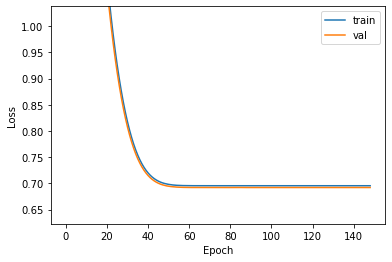

In [11]:
### Step 3: Train the model
# Maximum number of iterations through the data set
epochs     = 1000
# If no improvement after 30 epochs, training stops
patience   = 30
# Batch size should be 2^N
# You want to use the largest possible value for the problem at hand.
# This is determined by...experimenting!
# You want the largest batch size that doesn't result in memory errors 
# and does result in the model learning the problem
batch_size = 1024

# Now, train SkyNet!
TrainModel(model, 
           inputs_tr_norm,  circ_tr_norm, 
           inputs_val_norm, circ_val_norm, 
           batch_size, epochs, patience, 'LR_circ')

Normalized RMSE: [0.99577863 0.62653124]


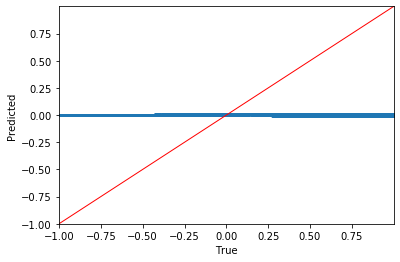

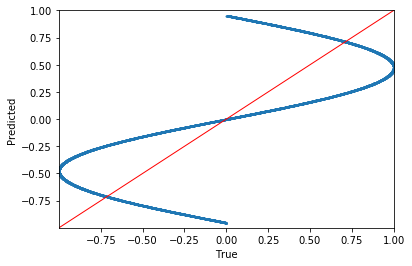

R2: [-2.31419725e-04  6.10801061e-01]


In [12]:
### Step 4: Validate the model
val_pred_denorm, rmse_val, r2_val = ValidateModel(model, 
                                                  inputs_val_norm, 
                                                  circ_val_norm, 
                                                  circ_tr_mean, 
                                                  circ_tr_stdev, 
                                                  batch_size, 
                                                  'LR_circ')

Weight file does not exist. Training new model.
Train on 70000 samples, validate on 10000 samples
Epoch 1/1000
70000/70000 [==============================] - 1s 9us/step - loss: 0.8657 - val_loss: 0.6695

Epoch 00001: val_loss improved from inf to 0.66946, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 2/1000
70000/70000 [==============================] - 0s 2us/step - loss: 0.6409 - val_loss: 0.6094

Epoch 00002: val_loss improved from 0.66946 to 0.60943, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 3/1000
70000/70000 [==============================] - 0s 3us/step - loss: 0.5770 - val_loss: 0.5316

Epoch 00003: val_loss improved from 0.60943 to 0.53158, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 4/1000
70000/70000 [==============================] - 1s 9us/step - loss: 0.4802 - val_loss: 0.4172

Epoch 00004: val_loss improved from 0.53158 to 0.41718, saving model to w


Epoch 00034: val_loss improved from 0.05433 to 0.04529, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 35/1000
70000/70000 [==============================] - 0s 2us/step - loss: 0.0410 - val_loss: 0.0380

Epoch 00035: val_loss improved from 0.04529 to 0.03796, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 36/1000
70000/70000 [==============================] - 0s 4us/step - loss: 0.0342 - val_loss: 0.0314

Epoch 00036: val_loss improved from 0.03796 to 0.03136, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 37/1000
70000/70000 [==============================] - 0s 3us/step - loss: 0.0289 - val_loss: 0.0269

Epoch 00037: val_loss improved from 0.03136 to 0.02686, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 38/1000
70000/70000 [==============================] - 0s 2us/step - loss: 0.0249 - val_loss: 0.0235

Epoch 00038: val_loss impro

Epoch 101/1000
70000/70000 [==============================] - 0s 2us/step - loss: 2.9267e-04 - val_loss: 3.1535e-04

Epoch 00101: val_loss did not improve from 0.00031
Epoch 102/1000
70000/70000 [==============================] - 0s 5us/step - loss: 2.8639e-04 - val_loss: 2.8241e-04

Epoch 00102: val_loss improved from 0.00031 to 0.00028, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 103/1000
70000/70000 [==============================] - 0s 2us/step - loss: 2.7490e-04 - val_loss: 2.8432e-04

Epoch 00103: val_loss did not improve from 0.00028
Epoch 104/1000
70000/70000 [==============================] - 0s 2us/step - loss: 2.6765e-04 - val_loss: 2.7349e-04

Epoch 00104: val_loss improved from 0.00028 to 0.00027, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 105/1000
70000/70000 [==============================] - 0s 3us/step - loss: 2.5994e-04 - val_loss: 2.5915e-04

Epoch 00105: val_loss improved from 0.00027

70000/70000 [==============================] - 0s 3us/step - loss: 1.1941e-04 - val_loss: 1.1546e-04

Epoch 00137: val_loss improved from 0.00012 to 0.00012, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 138/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.1597e-04 - val_loss: 1.2510e-04

Epoch 00138: val_loss did not improve from 0.00012
Epoch 139/1000
70000/70000 [==============================] - 0s 3us/step - loss: 1.1741e-04 - val_loss: 1.1291e-04

Epoch 00139: val_loss improved from 0.00012 to 0.00011, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 140/1000
70000/70000 [==============================] - 0s 4us/step - loss: 1.1296e-04 - val_loss: 1.1098e-04

Epoch 00140: val_loss improved from 0.00011 to 0.00011, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 141/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.0778e-0

70000/70000 [==============================] - 0s 2us/step - loss: 6.2276e-05 - val_loss: 6.4254e-05

Epoch 00178: val_loss did not improve from 0.00006
Epoch 179/1000
70000/70000 [==============================] - 0s 4us/step - loss: 5.8420e-05 - val_loss: 6.9363e-05

Epoch 00179: val_loss did not improve from 0.00006
Epoch 180/1000
70000/70000 [==============================] - 0s 5us/step - loss: 5.9540e-05 - val_loss: 6.6308e-05

Epoch 00180: val_loss did not improve from 0.00006
Epoch 181/1000
70000/70000 [==============================] - 0s 3us/step - loss: 5.8534e-05 - val_loss: 5.7945e-05

Epoch 00181: val_loss improved from 0.00006 to 0.00006, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 182/1000
70000/70000 [==============================] - 0s 2us/step - loss: 5.5328e-05 - val_loss: 5.6213e-05

Epoch 00182: val_loss improved from 0.00006 to 0.00006, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 1

70000/70000 [==============================] - 0s 4us/step - loss: 3.3908e-05 - val_loss: 3.4783e-05

Epoch 00220: val_loss improved from 0.00004 to 0.00003, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 221/1000
70000/70000 [==============================] - 0s 2us/step - loss: 3.4038e-05 - val_loss: 3.2199e-05

Epoch 00221: val_loss improved from 0.00003 to 0.00003, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 222/1000
70000/70000 [==============================] - 0s 2us/step - loss: 3.3557e-05 - val_loss: 3.8942e-05

Epoch 00222: val_loss did not improve from 0.00003
Epoch 223/1000
70000/70000 [==============================] - 0s 5us/step - loss: 3.4321e-05 - val_loss: 2.9973e-05

Epoch 00223: val_loss improved from 0.00003 to 0.00003, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 224/1000
70000/70000 [==============================] - 0s 3us/step - loss: 3.1358e-0

70000/70000 [==============================] - 0s 3us/step - loss: 1.7458e-05 - val_loss: 1.4869e-05

Epoch 00306: val_loss did not improve from 0.00001
Epoch 307/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.7227e-05 - val_loss: 1.9383e-05

Epoch 00307: val_loss did not improve from 0.00001
Epoch 308/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.6152e-05 - val_loss: 1.5820e-05

Epoch 00308: val_loss did not improve from 0.00001
Epoch 309/1000
70000/70000 [==============================] - 0s 4us/step - loss: 1.5484e-05 - val_loss: 1.7185e-05

Epoch 00309: val_loss did not improve from 0.00001
Epoch 310/1000
70000/70000 [==============================] - 0s 6us/step - loss: 1.6289e-05 - val_loss: 1.6907e-05

Epoch 00310: val_loss did not improve from 0.00001
Epoch 311/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.6069e-05 - val_loss: 1.5672e-05

Epoch 00311: val_loss did not improve from 0.00001
Epoch 3

70000/70000 [==============================] - 0s 2us/step - loss: 9.5577e-06 - val_loss: 1.5650e-05

Epoch 00396: val_loss did not improve from 0.00001
Epoch 397/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.0107e-05 - val_loss: 1.6225e-05

Epoch 00397: val_loss did not improve from 0.00001
Epoch 398/1000
70000/70000 [==============================] - 0s 4us/step - loss: 1.0921e-05 - val_loss: 1.0921e-05

Epoch 00398: val_loss did not improve from 0.00001
Epoch 399/1000
70000/70000 [==============================] - 0s 4us/step - loss: 1.0451e-05 - val_loss: 8.5140e-06

Epoch 00399: val_loss improved from 0.00001 to 0.00001, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 400/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.0087e-05 - val_loss: 8.4867e-06

Epoch 00400: val_loss improved from 0.00001 to 0.00001, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 4

70000/70000 [==============================] - 0s 4us/step - loss: 8.4007e-06 - val_loss: 1.1580e-05

Epoch 00488: val_loss did not improve from 0.00001
Epoch 489/1000
70000/70000 [==============================] - 0s 2us/step - loss: 8.4392e-06 - val_loss: 6.4702e-06

Epoch 00489: val_loss did not improve from 0.00001
Epoch 490/1000
70000/70000 [==============================] - 0s 2us/step - loss: 8.0893e-06 - val_loss: 6.8136e-06

Epoch 00490: val_loss did not improve from 0.00001
Epoch 491/1000
70000/70000 [==============================] - 0s 4us/step - loss: 7.8878e-06 - val_loss: 1.2570e-05

Epoch 00491: val_loss did not improve from 0.00001
Epoch 492/1000
70000/70000 [==============================] - 0s 4us/step - loss: 7.1813e-06 - val_loss: 5.7375e-06

Epoch 00492: val_loss improved from 0.00001 to 0.00001, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 493/1000
70000/70000 [==============================] - 0s 2us/step - loss: 8.6125e-0

70000/70000 [==============================] - 0s 3us/step - loss: 9.4009e-06 - val_loss: 7.4751e-06

Epoch 00535: val_loss did not improve from 0.00001
Epoch 536/1000
70000/70000 [==============================] - 0s 2us/step - loss: 8.3823e-06 - val_loss: 5.0343e-06

Epoch 00536: val_loss improved from 0.00001 to 0.00001, saving model to weights/hidden1_64node_elu_circ_checkpoint_weights_mse_loss.h5
Epoch 537/1000
70000/70000 [==============================] - 0s 3us/step - loss: 6.1563e-06 - val_loss: 5.8387e-06

Epoch 00537: val_loss did not improve from 0.00001
Epoch 538/1000
70000/70000 [==============================] - 0s 2us/step - loss: 6.4260e-06 - val_loss: 8.6548e-06

Epoch 00538: val_loss did not improve from 0.00001
Epoch 539/1000
70000/70000 [==============================] - 0s 3us/step - loss: 7.3079e-06 - val_loss: 6.6966e-06

Epoch 00539: val_loss did not improve from 0.00001
Epoch 540/1000
70000/70000 [==============================] - 0s 5us/step - loss: 7.0777e-0

70000/70000 [==============================] - 0s 2us/step - loss: 5.8395e-06 - val_loss: 7.7680e-06

Epoch 00582: val_loss did not improve from 0.00000
Epoch 583/1000
70000/70000 [==============================] - 0s 4us/step - loss: 6.0574e-06 - val_loss: 5.9061e-06

Epoch 00583: val_loss did not improve from 0.00000
Epoch 584/1000
70000/70000 [==============================] - 0s 3us/step - loss: 6.9324e-06 - val_loss: 5.5368e-06

Epoch 00584: val_loss did not improve from 0.00000
Epoch 585/1000
70000/70000 [==============================] - 0s 2us/step - loss: 1.0572e-05 - val_loss: 5.8708e-06

Epoch 00585: val_loss did not improve from 0.00000
Epoch 586/1000
70000/70000 [==============================] - 0s 3us/step - loss: 5.9687e-06 - val_loss: 5.0877e-06

Epoch 00586: val_loss did not improve from 0.00000
Epoch 587/1000
70000/70000 [==============================] - 1s 8us/step - loss: 5.4496e-06 - val_loss: 6.5848e-06

Epoch 00587: val_loss did not improve from 0.00000
Epoch 5

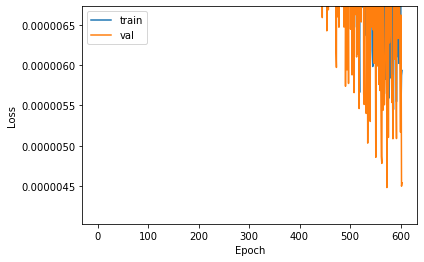

Normalized RMSE: [0.00173027 0.0024683 ]


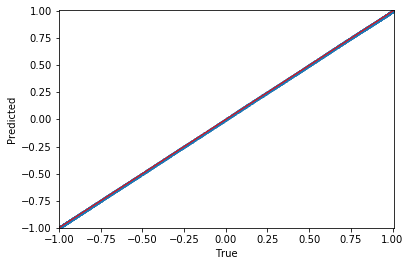

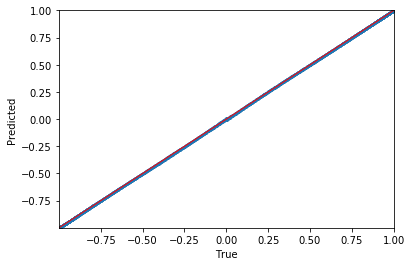

R2: [0.99999698 0.99999396]


In [13]:
# So, it does horribly, like we would expect -- this is not a linear problem
# Let's start adding layers and nodes
layers = [64]
activ  = ['elu']
fname  = 'hidden1_64node_elu_circ'

model, val_pred_denorm, rmse_val, r2_val = \
                 TrainValArch(inputs_tr_norm,  circ_tr_norm, 
                              inputs_val_norm, circ_val_norm,
                              circ_tr_mean,    circ_tr_stdev, 
                              layers, activ, learnrate, 
                              batch_size, epochs, patience, fname)

Normalized RMSE: [0.00170567 0.00248858]


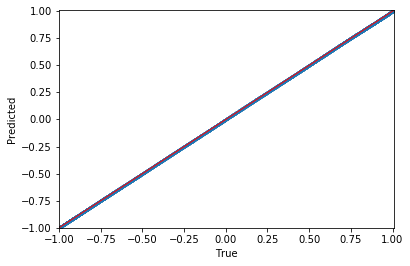

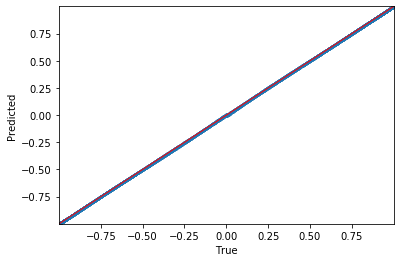

R2: [0.99999709 0.99999381]


In [14]:
# R^2 > 0.999 -- great model
### Step 5: Apply model to the test set
#   Note: We have a validated model that is 'good', 
#   but that doesn't mean it's a generalized model!  
#   This is why we run it on the test set, which it has not seen until now
te_pred_denorm, rmse_te, r2_te = TestModel(model, 
                                           inputs_te_norm, 
                                           circ_te_norm, 
                                           circ_tr_mean, 
                                           circ_tr_stdev, 
                                           batch_size, 
                                           fname)

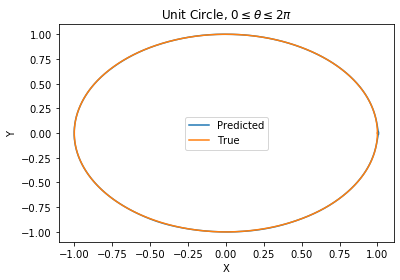

In [15]:
# The model generalized well, as expected
#Let's do some test cases!
# Test case 1: unit circle (what it was trained to do)
t1_n     = 1000
t1_theta = np.expand_dims(np.linspace(0, 2*np.pi, t1_n), -1)
# Analytical values
t1_true  = np.hstack([np.cos(t1_theta), np.sin(t1_theta)])
# Normalize input, predict, denormalize
t1_inp   = (t1_theta - inputs_tr_mean) / inputs_tr_stdev
t1_pred  = model.predict(t1_inp) * circ_tr_stdev + circ_tr_mean

# Plot it
plt.plot(t1_pred[:,0], t1_pred[:,1], label='Predicted')
plt.plot(t1_true[:,0], t1_true[:,1], label='True')
plt.title("Unit Circle, $0 \leq \\theta \leq 2\pi$")
plt.ylabel('Y')
plt.legend(loc='best')
plt.xlabel('X')
plt.savefig('plots/'+fname+'_test_unitcircle_0-2pi.png', bbox_inches='tight')
plt.show()

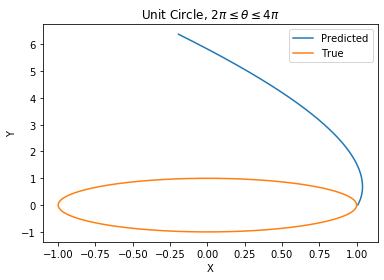

In [16]:
# Looks like a circle! That last predicted point seems slightly off, though
# What happens if we predict a circle from 2pi -- 4pi?
t2_theta = np.expand_dims(np.linspace(2*np.pi, 4*np.pi, t1_n), -1)
# Analytical values
t2_true  = np.hstack([np.cos(t2_theta), np.sin(t2_theta)])
# Normalize input, predict, denormalize
t2_inp   = (t2_theta - inputs_tr_mean) / inputs_tr_stdev
t2_pred  = model.predict(t2_inp) * circ_tr_stdev + circ_tr_mean

# Plot it
plt.plot(t2_pred[:,0], t2_pred[:,1], label='Predicted')
plt.plot(t2_true[:,0], t2_true[:,1], label='True')
plt.title("Unit Circle, $2\pi \leq \\theta \leq 4\pi$")
plt.ylabel('Y')
plt.legend(loc='best')
plt.xlabel('X')
plt.savefig('plots/'+fname+'_test_unitcircle_2pi-4pi.png', bbox_inches='tight')
plt.show()

In [17]:
# Not so circular :)
# This is why you cannot reliably apply ML models outside of the training space
# But, if you know you have periodic behavior like this, then you could shift 
# the inputs to be within the training space before predicting with the ML model

# Gaussian

In [18]:
def gaussian(x, mu=0., sigma=1., scale=1.):
    """
    Function to calculate a Gaussian.

    Inputs
    ------
    x    : array or float. Position(s) to calculate Gaussian.
    mu   : float. Mean value of Gaussian.
    sigma: float. Standard deviation of Gaussian.
    scale: float. Scaling factor.

    Outputs
    -------
    values: array or float. Value of the Gaussian at `x`.

    Example
    -------
    >>> gaussian(x=10, mu=10, sigma=1)
    0.3989422804014327

    >>> gaussian(x=1, mu=10, sigma=1)
    1.0279773571668917e-18

    >>> gaussian(x=1, mu=0, sigma=1)
    0.24197072451914337

    >>> gaussian(x=1, mu=0, sigma=100)
    0.003989223337860822

    Revisions
    ---------
    2019-11-05  Michael Himes           Initial implementation.
    """
    return scale/sigma/np.sqrt(2.*np.pi) * np.exp(-(1./2.) * ((x-mu)/sigma)**2)

In [19]:
### Step 1: Generate the data
np.random.seed(0)

# Set boundaries, number of samples
mulo   , muhi    = 30  , 50
sigmalo, sigmahi =  0.1, 10
nsamp            = 500000 # Decrease this for faster, less accurate training

# Make draws from random uniform distribution -- NN inputs
# We want a good selection of values, 
# not just values far from the mean (and therefore ~0)
# First, we pick mu and sigma. Then, we'll pick x based on those.
inputs      = np.zeros((nsamp, 3))
inputs[:,1] = np.random.uniform(mulo   , muhi   , nsamp)
inputs[:,2] = np.random.uniform(sigmalo, sigmahi, nsamp)
inputs[:,0] = inputs[:,1] + np.random.uniform(-3*inputs[:,2], 3*inputs[:,2])


# Calculate the Gaussian value for all cases -- NN outputs
gaus = gaussian(inputs[:,0], inputs[:,1], inputs[:,2])
# Making `gaus` into a 2D array for consistency
gaus = np.expand_dims(gaus, -1)

# Split `inputs` and `gaus` into training, validation, and test sets
ntr  = int(nsamp * 0.7)
nval = int(nsamp * 0.1)
nte  = int(nsamp * 0.2)

inputs_tr  = inputs[        :ntr         ]
inputs_val = inputs[ntr     :ntr+nval    ]
inputs_te  = inputs[ntr+nval:ntr+nval+nte]

gaus_tr  = gaus[        :ntr         ]
gaus_val = gaus[ntr     :ntr+nval    ]
gaus_te  = gaus[ntr+nval:ntr+nval+nte]

# Normalize the data based on the training data
inputs_tr_mean  = np.mean(inputs_tr, axis=0)
inputs_tr_stdev = np.std (inputs_tr, axis=0)

gaus_tr_mean  = np.mean(gaus_tr, axis=0)
gaus_tr_stdev = np.std (gaus_tr, axis=0)

inputs_tr_norm  = (inputs_tr  - inputs_tr_mean) / inputs_tr_stdev
inputs_val_norm = (inputs_val - inputs_tr_mean) / inputs_tr_stdev
inputs_te_norm  = (inputs_te  - inputs_tr_mean) / inputs_tr_stdev

gaus_tr_norm  = (gaus_tr  - gaus_tr_mean) / gaus_tr_stdev
gaus_val_norm = (gaus_val - gaus_tr_mean) / gaus_tr_stdev
gaus_te_norm  = (gaus_te  - gaus_tr_mean) / gaus_tr_stdev

In [20]:
### Step 2: Define the model
learnrate = 5e-3
# No hidden layers -- linear regression model
model = DenseNet(inputs.shape[-1], gaus_tr.shape[-1], learnrate=learnrate)

Weight file does not exist. Training new model.
Train on 350000 samples, validate on 50000 samples
Epoch 1/1000
350000/350000 [==============================] - 1s 2us/step - loss: 1.1128 - val_loss: 0.8906

Epoch 00001: val_loss improved from inf to 0.89062, saving model to weights/LR_gaus_checkpoint_weights_mse_loss.h5
Epoch 2/1000
350000/350000 [==============================] - 0s 1us/step - loss: 0.8517 - val_loss: 0.8863

Epoch 00002: val_loss improved from 0.89062 to 0.88634, saving model to weights/LR_gaus_checkpoint_weights_mse_loss.h5
Epoch 3/1000
350000/350000 [==============================] - 0s 1us/step - loss: 0.8510 - val_loss: 0.8863

Epoch 00003: val_loss improved from 0.88634 to 0.88634, saving model to weights/LR_gaus_checkpoint_weights_mse_loss.h5
Epoch 4/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.8511 - val_loss: 0.8862

Epoch 00004: val_loss improved from 0.88634 to 0.88615, saving model to weights/LR_gaus_checkpoint_weights_mse_l

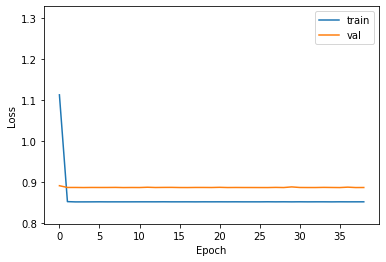

In [21]:
### Step 3: Train the model
epochs     = 1000
patience   = 30
batch_size = 1024

TrainModel(model, 
           inputs_tr_norm,  gaus_tr_norm, 
           inputs_val_norm, gaus_val_norm, 
           batch_size, epochs, patience, 'LR_gaus')

Normalized RMSE: [0.94140253]


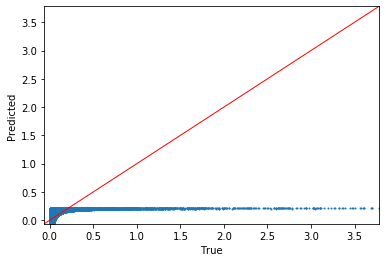

R2: [0.14439345]


In [22]:
### Step 4: Validate the model
val_pred_denorm, rmse_val, r2_val = ValidateModel(model, 
                                                  inputs_val_norm, 
                                                  gaus_val_norm, 
                                                  gaus_tr_mean, 
                                                  gaus_tr_stdev, 
                                                  batch_size, 
                                                  'LR_gaus')

Weight file does not exist. Training new model.
Train on 350000 samples, validate on 50000 samples
Epoch 1/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.8281 - val_loss: 0.7649

Epoch 00001: val_loss improved from inf to 0.76485, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 2/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.6918 - val_loss: 0.6990

Epoch 00002: val_loss improved from 0.76485 to 0.69898, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 3/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.6432 - val_loss: 0.6616

Epoch 00003: val_loss improved from 0.69898 to 0.66158, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 4/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.6136 - val_loss: 0.6365

Epoch 00004: val_loss improved from 0.66158 to 0.63647, saving m


Epoch 00075: val_loss did not improve from 0.45207
Epoch 76/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4194 - val_loss: 0.4506

Epoch 00076: val_loss improved from 0.45207 to 0.45060, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 77/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.4177 - val_loss: 0.4508

Epoch 00077: val_loss did not improve from 0.45060
Epoch 78/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4176 - val_loss: 0.4493

Epoch 00078: val_loss improved from 0.45060 to 0.44934, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 79/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4177 - val_loss: 0.4547

Epoch 00079: val_loss did not improve from 0.44934
Epoch 80/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4174 - val_loss: 0.4478

Epoch 00080: val_loss impr

350000/350000 [==============================] - 1s 2us/step - loss: 0.3857 - val_loss: 0.4165

Epoch 00159: val_loss did not improve from 0.41531
Epoch 160/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3856 - val_loss: 0.4170

Epoch 00160: val_loss did not improve from 0.41531
Epoch 161/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3839 - val_loss: 0.4155

Epoch 00161: val_loss did not improve from 0.41531
Epoch 162/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3840 - val_loss: 0.4139

Epoch 00162: val_loss improved from 0.41531 to 0.41395, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 163/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3837 - val_loss: 0.4187

Epoch 00163: val_loss did not improve from 0.41395
Epoch 164/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3839 - val_loss: 0.4148

Epoch 0016

350000/350000 [==============================] - 1s 3us/step - loss: 0.3737 - val_loss: 0.4040

Epoch 00203: val_loss did not improve from 0.40394
Epoch 204/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3738 - val_loss: 0.4033

Epoch 00204: val_loss improved from 0.40394 to 0.40327, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 205/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3730 - val_loss: 0.4038

Epoch 00205: val_loss did not improve from 0.40327
Epoch 206/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3720 - val_loss: 0.4049

Epoch 00206: val_loss did not improve from 0.40327
Epoch 207/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3729 - val_loss: 0.4022

Epoch 00207: val_loss improved from 0.40327 to 0.40216, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 208/1000
350000/350000 [=======

350000/350000 [==============================] - 1s 2us/step - loss: 0.3637 - val_loss: 0.3943

Epoch 00248: val_loss did not improve from 0.39356
Epoch 249/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3659 - val_loss: 0.3952

Epoch 00249: val_loss did not improve from 0.39356
Epoch 250/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3657 - val_loss: 0.3985

Epoch 00250: val_loss did not improve from 0.39356
Epoch 251/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3639 - val_loss: 0.3943

Epoch 00251: val_loss did not improve from 0.39356
Epoch 252/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3628 - val_loss: 0.3921

Epoch 00252: val_loss improved from 0.39356 to 0.39209, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 253/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3637 - val_loss: 0.3962

Epoch 0025

350000/350000 [==============================] - 1s 2us/step - loss: 0.3521 - val_loss: 0.3768

Epoch 00336: val_loss improved from 0.37701 to 0.37682, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 337/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3520 - val_loss: 0.3787

Epoch 00337: val_loss did not improve from 0.37682
Epoch 338/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3501 - val_loss: 0.3770

Epoch 00338: val_loss did not improve from 0.37682
Epoch 339/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3498 - val_loss: 0.3783

Epoch 00339: val_loss did not improve from 0.37682
Epoch 340/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3490 - val_loss: 0.3770

Epoch 00340: val_loss did not improve from 0.37682
Epoch 341/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3497 - val_loss: 0.3817

Epoch 0034

350000/350000 [==============================] - 1s 2us/step - loss: 0.3441 - val_loss: 0.3745

Epoch 00381: val_loss did not improve from 0.37070
Epoch 382/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3441 - val_loss: 0.3711

Epoch 00382: val_loss did not improve from 0.37070
Epoch 383/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3450 - val_loss: 0.3769

Epoch 00383: val_loss did not improve from 0.37070
Epoch 384/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3456 - val_loss: 0.3703

Epoch 00384: val_loss improved from 0.37070 to 0.37031, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 385/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3438 - val_loss: 0.3788

Epoch 00385: val_loss did not improve from 0.37031
Epoch 386/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3445 - val_loss: 0.3697

Epoch 0038

350000/350000 [==============================] - 1s 2us/step - loss: 0.3348 - val_loss: 0.3602

Epoch 00473: val_loss did not improve from 0.35979
Epoch 474/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3341 - val_loss: 0.3602

Epoch 00474: val_loss did not improve from 0.35979
Epoch 475/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3343 - val_loss: 0.3614

Epoch 00475: val_loss did not improve from 0.35979
Epoch 476/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3345 - val_loss: 0.3594

Epoch 00476: val_loss improved from 0.35979 to 0.35944, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 477/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3339 - val_loss: 0.3590

Epoch 00477: val_loss improved from 0.35944 to 0.35896, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 478/1000
350000/350000 [=======

350000/350000 [==============================] - 1s 2us/step - loss: 0.3298 - val_loss: 0.3557

Epoch 00519: val_loss did not improve from 0.35517
Epoch 520/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3315 - val_loss: 0.3561

Epoch 00520: val_loss did not improve from 0.35517
Epoch 521/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3322 - val_loss: 0.3577

Epoch 00521: val_loss did not improve from 0.35517
Epoch 522/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3302 - val_loss: 0.3545

Epoch 00522: val_loss improved from 0.35517 to 0.35450, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 523/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3294 - val_loss: 0.3584

Epoch 00523: val_loss did not improve from 0.35450
Epoch 524/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3312 - val_loss: 0.3577

Epoch 0052

350000/350000 [==============================] - 1s 2us/step - loss: 0.3281 - val_loss: 0.3518

Epoch 00565: val_loss did not improve from 0.35164
Epoch 566/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3275 - val_loss: 0.3560

Epoch 00566: val_loss did not improve from 0.35164
Epoch 567/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3272 - val_loss: 0.3533

Epoch 00567: val_loss did not improve from 0.35164
Epoch 568/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3274 - val_loss: 0.3547

Epoch 00568: val_loss did not improve from 0.35164
Epoch 569/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3265 - val_loss: 0.3586

Epoch 00569: val_loss did not improve from 0.35164
Epoch 570/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3266 - val_loss: 0.3539

Epoch 00570: val_loss did not improve from 0.35164
Epoch 571/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 2us/step - loss: 0.3236 - val_loss: 0.3475

Epoch 00611: val_loss improved from 0.34776 to 0.34754, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 612/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3241 - val_loss: 0.3540

Epoch 00612: val_loss did not improve from 0.34754
Epoch 613/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3238 - val_loss: 0.3531

Epoch 00613: val_loss did not improve from 0.34754
Epoch 614/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3244 - val_loss: 0.3495

Epoch 00614: val_loss did not improve from 0.34754
Epoch 615/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3232 - val_loss: 0.3516

Epoch 00615: val_loss did not improve from 0.34754
Epoch 616/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3231 - val_loss: 0.3466

Epoch 0061

350000/350000 [==============================] - 1s 2us/step - loss: 0.3194 - val_loss: 0.3516

Epoch 00657: val_loss did not improve from 0.34324
Epoch 658/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3215 - val_loss: 0.3446

Epoch 00658: val_loss did not improve from 0.34324
Epoch 659/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3198 - val_loss: 0.3448

Epoch 00659: val_loss did not improve from 0.34324
Epoch 660/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3203 - val_loss: 0.3434

Epoch 00660: val_loss did not improve from 0.34324
Epoch 661/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3215 - val_loss: 0.3460

Epoch 00661: val_loss did not improve from 0.34324
Epoch 662/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3210 - val_loss: 0.3457

Epoch 00662: val_loss did not improve from 0.34324
Epoch 663/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 2us/step - loss: 0.3173 - val_loss: 0.3445

Epoch 00705: val_loss did not improve from 0.34020
Epoch 706/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3197 - val_loss: 0.3544

Epoch 00706: val_loss did not improve from 0.34020
Epoch 707/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3174 - val_loss: 0.3411

Epoch 00707: val_loss did not improve from 0.34020
Epoch 708/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3171 - val_loss: 0.3557

Epoch 00708: val_loss did not improve from 0.34020
Epoch 709/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3170 - val_loss: 0.3405

Epoch 00709: val_loss did not improve from 0.34020
Epoch 710/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3171 - val_loss: 0.3413

Epoch 00710: val_loss did not improve from 0.34020
Epoch 711/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 1us/step - loss: 0.3160 - val_loss: 0.3383

Epoch 00753: val_loss did not improve from 0.33737
Epoch 754/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3152 - val_loss: 0.3456

Epoch 00754: val_loss did not improve from 0.33737
Epoch 755/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3156 - val_loss: 0.3400

Epoch 00755: val_loss did not improve from 0.33737
Epoch 756/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3150 - val_loss: 0.3428

Epoch 00756: val_loss did not improve from 0.33737
Epoch 757/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3143 - val_loss: 0.3383

Epoch 00757: val_loss did not improve from 0.33737
Epoch 758/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3154 - val_loss: 0.3388

Epoch 00758: val_loss did not improve from 0.33737
Epoch 759/1000
350000/350000 [=============


Epoch 00800: val_loss improved from 0.33498 to 0.33427, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 801/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3135 - val_loss: 0.3380

Epoch 00801: val_loss did not improve from 0.33427
Epoch 802/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3122 - val_loss: 0.3376

Epoch 00802: val_loss did not improve from 0.33427
Epoch 803/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3123 - val_loss: 0.3337

Epoch 00803: val_loss improved from 0.33427 to 0.33367, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 804/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3116 - val_loss: 0.3351

Epoch 00804: val_loss did not improve from 0.33367
Epoch 805/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3124 - val_loss: 0.3364

Epoch 00805: val_loss


Epoch 00848: val_loss did not improve from 0.33174
Epoch 849/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3107 - val_loss: 0.3350

Epoch 00849: val_loss did not improve from 0.33174
Epoch 850/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3112 - val_loss: 0.3320

Epoch 00850: val_loss did not improve from 0.33174
Epoch 851/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3104 - val_loss: 0.3329

Epoch 00851: val_loss did not improve from 0.33174
Epoch 852/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3104 - val_loss: 0.3324

Epoch 00852: val_loss did not improve from 0.33174
Epoch 853/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3090 - val_loss: 0.3335

Epoch 00853: val_loss did not improve from 0.33174
Epoch 854/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3090 - val_loss: 0.3336

Epoch 00854: val_loss did n

350000/350000 [==============================] - 1s 2us/step - loss: 0.3061 - val_loss: 0.3331

Epoch 00945: val_loss did not improve from 0.32784
Epoch 946/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3059 - val_loss: 0.3276

Epoch 00946: val_loss improved from 0.32784 to 0.32758, saving model to weights/hidden1_4node_tanh_gaus_checkpoint_weights_mse_loss.h5
Epoch 947/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3077 - val_loss: 0.3278

Epoch 00947: val_loss did not improve from 0.32758
Epoch 948/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3061 - val_loss: 0.3282

Epoch 00948: val_loss did not improve from 0.32758
Epoch 949/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3067 - val_loss: 0.3311

Epoch 00949: val_loss did not improve from 0.32758
Epoch 950/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3073 - val_loss: 0.3321

Epoch 0095

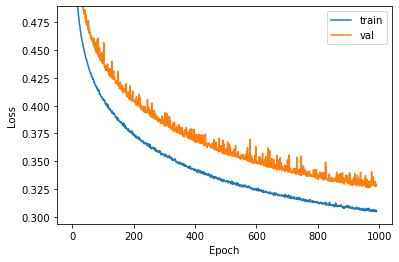

Normalized RMSE: [0.57303529]


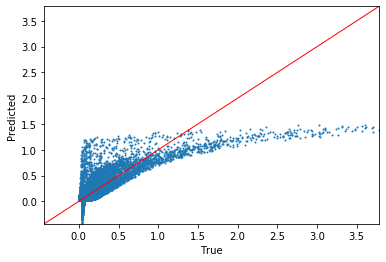

R2: [0.6829804]


In [23]:
# Well, that's disappointing...It predicts a horizontal line!
# Its error is usually ~1 sigma, and R^2 is basically 0!
# Dumb neural network...
# What does this mean? Well, it depends on the problem
# Here it means that the model is not complex enough to model the data.
# Let's try adding a hidden layer
layers = [4]
activ  = ['tanh']
fname  = 'hidden1_4node_tanh_gaus'

model, val_pred_denorm, rmse_val, r2_val = \
            TrainValArch(inputs_tr_norm,  gaus_tr_norm, 
                         inputs_val_norm, gaus_val_norm,
                         gaus_tr_mean,  gaus_tr_stdev, 
                         layers, activ, learnrate, 
                         batch_size, epochs, patience, fname)

In [24]:
# Well, it's better...kinda...but it's wrong for a lot of the cases! Why?

# Let's think about the problem at hand -- 
# the parameters are position, mean, and standard deviation.
# But, we can reduce the dimensionality of the problem to just 
# the position and standard deviation!
# If we have (x= 9, mu=10, sigma=10), this has the same values as 
#            (x=-1, mu=0,  sigma=10)
# So, let's go back to the beginning and train on just x and sigma 
# by shifting x based on mu. 
# This may not fix all of our problems, but it will simplify training, 
# which should help it learn/generalize better

In [25]:
# Set the data
new_inputs      = np.zeros((nsamp, 2))
new_inputs[:,0] = inputs[:,0] - inputs[:,1] # x - mu
new_inputs[:,1] = inputs[:,2]               # sigma
# Calculate Gaussian values
new_gaus = gaussian(new_inputs[:,0], sigma=new_inputs[:,1])
new_gaus = np.expand_dims(new_gaus, -1)
# Split into training, validation, test sets
new_inputs_tr  = new_inputs[        :ntr         ]
new_inputs_val = new_inputs[ntr     :ntr+nval    ]
new_inputs_te  = new_inputs[ntr+nval:ntr+nval+nte]
new_gaus_tr    = new_gaus  [        :ntr         ]
new_gaus_val   = new_gaus  [ntr     :ntr+nval    ]
new_gaus_te    = new_gaus  [ntr+nval:ntr+nval+nte]
# Normalize
new_inputs_tr_mean  = np.mean(new_inputs_tr, axis=0)
new_inputs_tr_stdev = np.std (new_inputs_tr, axis=0)
new_gaus_tr_mean    = np.mean(new_gaus_tr,   axis=0)
new_gaus_tr_stdev   = np.std (new_gaus_tr,   axis=0)
new_inputs_tr_norm  = (new_inputs_tr  - new_inputs_tr_mean) / new_inputs_tr_stdev
new_inputs_val_norm = (new_inputs_val - new_inputs_tr_mean) / new_inputs_tr_stdev
new_inputs_te_norm  = (new_inputs_te  - new_inputs_tr_mean) / new_inputs_tr_stdev
new_gaus_tr_norm    = (new_gaus_tr    - new_gaus_tr_mean)   / new_gaus_tr_stdev
new_gaus_val_norm   = (new_gaus_val   - new_gaus_tr_mean)   / new_gaus_tr_stdev
new_gaus_te_norm    = (new_gaus_te    - new_gaus_tr_mean)   / new_gaus_tr_stdev

Weight file does not exist. Training new model.
Train on 350000 samples, validate on 50000 samples
Epoch 1/1000
350000/350000 [==============================] - 1s 3us/step - loss: 1.0335 - val_loss: 0.8257

Epoch 00001: val_loss improved from inf to 0.82570, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 2/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.7595 - val_loss: 0.7633

Epoch 00002: val_loss improved from 0.82570 to 0.76333, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 3/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.7025 - val_loss: 0.7137

Epoch 00003: val_loss improved from 0.76333 to 0.71368, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 4/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.6602 - val_loss: 0.6785

Epoch 00004: val_loss improved from 0.71368 to


Epoch 00034: val_loss improved from 0.53684 to 0.53508, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 35/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4998 - val_loss: 0.5335

Epoch 00035: val_loss improved from 0.53508 to 0.53352, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 36/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4993 - val_loss: 0.5357

Epoch 00036: val_loss did not improve from 0.53352
Epoch 37/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4979 - val_loss: 0.5311

Epoch 00037: val_loss improved from 0.53352 to 0.53111, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 38/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4969 - val_loss: 0.5338

Epoch 00038: val_loss did not improve from 0.53111
Epoch 39/1000
350000/350000 [=====

350000/350000 [==============================] - 1s 2us/step - loss: 0.4753 - val_loss: 0.5112

Epoch 00074: val_loss did not improve from 0.50905
Epoch 75/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4753 - val_loss: 0.5085

Epoch 00075: val_loss improved from 0.50905 to 0.50848, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 76/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4744 - val_loss: 0.5108

Epoch 00076: val_loss did not improve from 0.50848
Epoch 77/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4736 - val_loss: 0.5097

Epoch 00077: val_loss did not improve from 0.50848
Epoch 78/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4741 - val_loss: 0.5076

Epoch 00078: val_loss improved from 0.50848 to 0.50760, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 79/1000
350000/350000 [

Epoch 115/1000
350000/350000 [==============================] - 0s 1us/step - loss: 0.4603 - val_loss: 0.4951

Epoch 00115: val_loss did not improve from 0.49457
Epoch 116/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4600 - val_loss: 0.4941

Epoch 00116: val_loss improved from 0.49457 to 0.49407, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 117/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.4597 - val_loss: 0.4937

Epoch 00117: val_loss improved from 0.49407 to 0.49368, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 118/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4603 - val_loss: 0.4931

Epoch 00118: val_loss improved from 0.49368 to 0.49309, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 119/1000
350000/350000 [==============================] - 0s 1us/step - loss

350000/350000 [==============================] - 1s 2us/step - loss: 0.4219 - val_loss: 0.4543

Epoch 00195: val_loss did not improve from 0.45421
Epoch 196/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4212 - val_loss: 0.4543

Epoch 00196: val_loss did not improve from 0.45421
Epoch 197/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4220 - val_loss: 0.4537

Epoch 00197: val_loss improved from 0.45421 to 0.45373, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 198/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4205 - val_loss: 0.4553

Epoch 00198: val_loss did not improve from 0.45373
Epoch 199/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4216 - val_loss: 0.4537

Epoch 00199: val_loss improved from 0.45373 to 0.45369, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 200/1000
350000/350

350000/350000 [==============================] - 1s 3us/step - loss: 0.4140 - val_loss: 0.4460

Epoch 00236: val_loss did not improve from 0.44480
Epoch 237/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4129 - val_loss: 0.4433

Epoch 00237: val_loss improved from 0.44480 to 0.44328, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 238/1000
350000/350000 [==============================] - 0s 1us/step - loss: 0.4132 - val_loss: 0.4434

Epoch 00238: val_loss did not improve from 0.44328
Epoch 239/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4124 - val_loss: 0.4433

Epoch 00239: val_loss did not improve from 0.44328
Epoch 240/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.4124 - val_loss: 0.4455

Epoch 00240: val_loss did not improve from 0.44328
Epoch 241/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.4118 - val_loss: 0.4453

Epoc

350000/350000 [==============================] - 1s 2us/step - loss: 0.4056 - val_loss: 0.4353

Epoch 00280: val_loss improved from 0.43561 to 0.43532, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 281/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4046 - val_loss: 0.4381

Epoch 00281: val_loss did not improve from 0.43532
Epoch 282/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4038 - val_loss: 0.4387

Epoch 00282: val_loss did not improve from 0.43532
Epoch 283/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4046 - val_loss: 0.4364

Epoch 00283: val_loss did not improve from 0.43532
Epoch 284/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4040 - val_loss: 0.4483

Epoch 00284: val_loss did not improve from 0.43532
Epoch 285/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.4039 - val_loss: 0.4352

Epoc

350000/350000 [==============================] - 1s 2us/step - loss: 0.3916 - val_loss: 0.4222

Epoch 00365: val_loss did not improve from 0.42111
Epoch 366/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3925 - val_loss: 0.4238

Epoch 00366: val_loss did not improve from 0.42111
Epoch 367/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3918 - val_loss: 0.4224

Epoch 00367: val_loss did not improve from 0.42111
Epoch 368/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3918 - val_loss: 0.4219

Epoch 00368: val_loss did not improve from 0.42111
Epoch 369/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3905 - val_loss: 0.4221

Epoch 00369: val_loss did not improve from 0.42111
Epoch 370/1000
350000/350000 [==============================] - 0s 1us/step - loss: 0.3927 - val_loss: 0.4238

Epoch 00370: val_loss did not improve from 0.42111
Epoch 371/1000
350000/350000 [=============


Epoch 00409: val_loss did not improve from 0.41537
Epoch 410/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3852 - val_loss: 0.4148

Epoch 00410: val_loss improved from 0.41537 to 0.41484, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 411/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3852 - val_loss: 0.4145

Epoch 00411: val_loss improved from 0.41484 to 0.41450, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 412/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3850 - val_loss: 0.4140

Epoch 00412: val_loss improved from 0.41450 to 0.41399, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 413/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3847 - val_loss: 0.4166

Epoch 00413: val_loss did not improve from 0.41399
Epoch 414/1000
350000/350000 [

350000/350000 [==============================] - 1s 2us/step - loss: 0.3800 - val_loss: 0.4119

Epoch 00452: val_loss did not improve from 0.40961
Epoch 453/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3802 - val_loss: 0.4094

Epoch 00453: val_loss improved from 0.40961 to 0.40942, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 454/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3795 - val_loss: 0.4149

Epoch 00454: val_loss did not improve from 0.40942
Epoch 455/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3802 - val_loss: 0.4087

Epoch 00455: val_loss improved from 0.40942 to 0.40869, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 456/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3792 - val_loss: 0.4125

Epoch 00456: val_loss did not improve from 0.40869
Epoch 457/1000
350000/350

350000/350000 [==============================] - 1s 2us/step - loss: 0.3753 - val_loss: 0.4130

Epoch 00496: val_loss did not improve from 0.40295
Epoch 497/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3746 - val_loss: 0.4052

Epoch 00497: val_loss did not improve from 0.40295
Epoch 498/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3754 - val_loss: 0.4064

Epoch 00498: val_loss did not improve from 0.40295
Epoch 499/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3757 - val_loss: 0.4029

Epoch 00499: val_loss improved from 0.40295 to 0.40286, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 500/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3740 - val_loss: 0.4036

Epoch 00500: val_loss did not improve from 0.40286
Epoch 501/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3733 - val_loss: 0.4057

Epoc


Epoch 00540: val_loss did not improve from 0.39785
Epoch 541/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3701 - val_loss: 0.3976

Epoch 00541: val_loss improved from 0.39785 to 0.39764, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 542/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3708 - val_loss: 0.4054

Epoch 00542: val_loss did not improve from 0.39764
Epoch 543/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3687 - val_loss: 0.3978

Epoch 00543: val_loss did not improve from 0.39764
Epoch 544/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3694 - val_loss: 0.3997

Epoch 00544: val_loss did not improve from 0.39764
Epoch 545/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3698 - val_loss: 0.3988

Epoch 00545: val_loss did not improve from 0.39764
Epoch 546/1000
350000/350000 [==================

350000/350000 [==============================] - 1s 2us/step - loss: 0.3658 - val_loss: 0.3930

Epoch 00585: val_loss improved from 0.39305 to 0.39301, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 586/1000
350000/350000 [==============================] - 1s 1us/step - loss: 0.3653 - val_loss: 0.3951

Epoch 00586: val_loss did not improve from 0.39301
Epoch 587/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3659 - val_loss: 0.3925

Epoch 00587: val_loss improved from 0.39301 to 0.39249, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 588/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3635 - val_loss: 0.3928

Epoch 00588: val_loss did not improve from 0.39249
Epoch 589/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3641 - val_loss: 0.3963

Epoch 00589: val_loss did not improve from 0.39249
Epoch 590/1000
350000/350

350000/350000 [==============================] - 1s 2us/step - loss: 0.3613 - val_loss: 0.4026

Epoch 00632: val_loss did not improve from 0.38783
Epoch 633/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3622 - val_loss: 0.3893

Epoch 00633: val_loss did not improve from 0.38783
Epoch 634/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3589 - val_loss: 0.3930

Epoch 00634: val_loss did not improve from 0.38783
Epoch 635/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3606 - val_loss: 0.3907

Epoch 00635: val_loss did not improve from 0.38783
Epoch 636/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3588 - val_loss: 0.3889

Epoch 00636: val_loss did not improve from 0.38783
Epoch 637/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3595 - val_loss: 0.3920

Epoch 00637: val_loss did not improve from 0.38783
Epoch 638/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 2us/step - loss: 0.3515 - val_loss: 0.3813

Epoch 00723: val_loss did not improve from 0.37801
Epoch 724/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3515 - val_loss: 0.3794

Epoch 00724: val_loss did not improve from 0.37801
Epoch 725/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3502 - val_loss: 0.3801

Epoch 00725: val_loss did not improve from 0.37801
Epoch 726/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3499 - val_loss: 0.3785

Epoch 00726: val_loss did not improve from 0.37801
Epoch 727/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3499 - val_loss: 0.3819

Epoch 00727: val_loss did not improve from 0.37801
Epoch 728/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3506 - val_loss: 0.3777

Epoch 00728: val_loss improved from 0.37801 to 0.37775, saving model to weights/hidden1_4node_

350000/350000 [==============================] - 1s 2us/step - loss: 0.3458 - val_loss: 0.3751

Epoch 00770: val_loss did not improve from 0.37453
Epoch 771/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3483 - val_loss: 0.3748

Epoch 00771: val_loss did not improve from 0.37453
Epoch 772/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3477 - val_loss: 0.3739

Epoch 00772: val_loss improved from 0.37453 to 0.37392, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 773/1000
350000/350000 [==============================] - 1s 1us/step - loss: 0.3466 - val_loss: 0.3736

Epoch 00773: val_loss improved from 0.37392 to 0.37358, saving model to weights/hidden1_4node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 774/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3471 - val_loss: 0.3742

Epoch 00774: val_loss did not improve from 0.37358
Epoch 775/1000
350000/350

350000/350000 [==============================] - 1s 2us/step - loss: 0.3394 - val_loss: 0.3677

Epoch 00860: val_loss did not improve from 0.36553
Epoch 861/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3380 - val_loss: 0.3752

Epoch 00861: val_loss did not improve from 0.36553
Epoch 862/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3403 - val_loss: 0.3847

Epoch 00862: val_loss did not improve from 0.36553
Epoch 863/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3376 - val_loss: 0.3703

Epoch 00863: val_loss did not improve from 0.36553
Epoch 864/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3387 - val_loss: 0.3716

Epoch 00864: val_loss did not improve from 0.36553
Epoch 865/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3394 - val_loss: 0.3666

Epoch 00865: val_loss did not improve from 0.36553
Epoch 866/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 2us/step - loss: 0.3355 - val_loss: 0.3634

Epoch 00907: val_loss did not improve from 0.36147
Epoch 908/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3352 - val_loss: 0.3712

Epoch 00908: val_loss did not improve from 0.36147
Epoch 909/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3357 - val_loss: 0.3616

Epoch 00909: val_loss did not improve from 0.36147
Epoch 910/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3350 - val_loss: 0.3618

Epoch 00910: val_loss did not improve from 0.36147
Epoch 911/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3338 - val_loss: 0.3615

Epoch 00911: val_loss did not improve from 0.36147
Epoch 912/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.3353 - val_loss: 0.3604

Epoch 00912: val_loss improved from 0.36147 to 0.36041, saving model to weights/hidden1_4node_

350000/350000 [==============================] - 1s 2us/step - loss: 0.3304 - val_loss: 0.3596

Epoch 00954: val_loss did not improve from 0.35772
Epoch 955/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3301 - val_loss: 0.3608

Epoch 00955: val_loss did not improve from 0.35772
Epoch 956/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3315 - val_loss: 0.3584

Epoch 00956: val_loss did not improve from 0.35772
Epoch 957/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3313 - val_loss: 0.3580

Epoch 00957: val_loss did not improve from 0.35772
Epoch 958/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3304 - val_loss: 0.3580

Epoch 00958: val_loss did not improve from 0.35772
Epoch 959/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.3325 - val_loss: 0.3584

Epoch 00959: val_loss did not improve from 0.35772
Epoch 960/1000
350000/350000 [=============

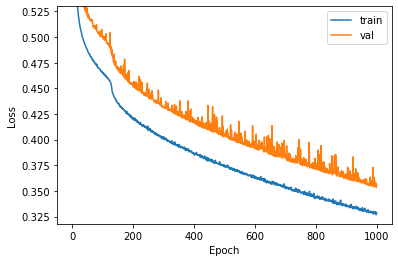

Normalized RMSE: [0.59527898]


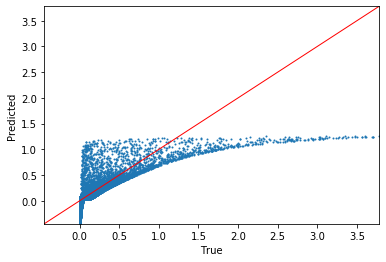

R2: [0.65789103]


In [26]:
# Run it through the previous model architecture
fname = 'hidden1_4node_tanh_gaus-shift'
model, val_pred_denorm, rmse_val, r2_val = \
                   TrainValArch(new_inputs_tr_norm,  new_gaus_tr_norm, 
                                new_inputs_val_norm, new_gaus_val_norm,
                                new_gaus_tr_mean,    new_gaus_tr_stdev, 
                                layers, activ, learnrate, 
                                batch_size, epochs, patience, fname)

Weight file does not exist. Training new model.
Train on 350000 samples, validate on 50000 samples
Epoch 1/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.7703 - val_loss: 0.7130

Epoch 00001: val_loss improved from inf to 0.71296, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 2/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.6367 - val_loss: 0.6386

Epoch 00002: val_loss improved from 0.71296 to 0.63857, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 3/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.5820 - val_loss: 0.5953

Epoch 00003: val_loss improved from 0.63857 to 0.59526, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 4/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.5412 - val_loss: 0.5562

Epoch 00004: val_loss improved from 0.59526

350000/350000 [==============================] - 1s 3us/step - loss: 0.2498 - val_loss: 0.2687

Epoch 00034: val_loss improved from 0.27034 to 0.26872, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 35/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.2486 - val_loss: 0.2653

Epoch 00035: val_loss improved from 0.26872 to 0.26529, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 36/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.2468 - val_loss: 0.2660

Epoch 00036: val_loss did not improve from 0.26529
Epoch 37/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.2449 - val_loss: 0.2643

Epoch 00037: val_loss improved from 0.26529 to 0.26426, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 38/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.2433 - val_l

350000/350000 [==============================] - 1s 3us/step - loss: 0.1479 - val_loss: 0.1603

Epoch 00106: val_loss did not improve from 0.15994
Epoch 107/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1471 - val_loss: 0.1613

Epoch 00107: val_loss did not improve from 0.15994
Epoch 108/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1471 - val_loss: 0.1582

Epoch 00108: val_loss improved from 0.15994 to 0.15816, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 109/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1458 - val_loss: 0.1596

Epoch 00109: val_loss did not improve from 0.15816
Epoch 110/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1460 - val_loss: 0.1612

Epoch 00110: val_loss did not improve from 0.15816
Epoch 111/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1461 - val_loss: 0.1573

Epo

350000/350000 [==============================] - 1s 2us/step - loss: 0.1230 - val_loss: 0.1313

Epoch 00191: val_loss improved from 0.13283 to 0.13134, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 192/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1227 - val_loss: 0.1322

Epoch 00192: val_loss did not improve from 0.13134
Epoch 193/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1223 - val_loss: 0.1347

Epoch 00193: val_loss did not improve from 0.13134
Epoch 194/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1230 - val_loss: 0.1330

Epoch 00194: val_loss did not improve from 0.13134
Epoch 195/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1226 - val_loss: 0.1378

Epoch 00195: val_loss did not improve from 0.13134
Epoch 196/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1229 - val_loss: 0.1309

Epo

350000/350000 [==============================] - 1s 2us/step - loss: 0.1168 - val_loss: 0.1249

Epoch 00235: val_loss did not improve from 0.12448
Epoch 236/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1170 - val_loss: 0.1305

Epoch 00236: val_loss did not improve from 0.12448
Epoch 237/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1167 - val_loss: 0.1256

Epoch 00237: val_loss did not improve from 0.12448
Epoch 238/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1165 - val_loss: 0.1259

Epoch 00238: val_loss did not improve from 0.12448
Epoch 239/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1170 - val_loss: 0.1248

Epoch 00239: val_loss did not improve from 0.12448
Epoch 240/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1163 - val_loss: 0.1243

Epoch 00240: val_loss improved from 0.12448 to 0.12430, saving model to weights/hidden1_16node

350000/350000 [==============================] - 1s 2us/step - loss: 0.1109 - val_loss: 0.1173

Epoch 00325: val_loss improved from 0.11771 to 0.11730, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 326/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1101 - val_loss: 0.1176

Epoch 00326: val_loss did not improve from 0.11730
Epoch 327/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1110 - val_loss: 0.1220

Epoch 00327: val_loss did not improve from 0.11730
Epoch 328/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1124 - val_loss: 0.1207

Epoch 00328: val_loss did not improve from 0.11730
Epoch 329/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1114 - val_loss: 0.1201

Epoch 00329: val_loss did not improve from 0.11730
Epoch 330/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1099 - val_loss: 0.1183

Epo

350000/350000 [==============================] - 1s 2us/step - loss: 0.1079 - val_loss: 0.1174

Epoch 00419: val_loss did not improve from 0.11369
Epoch 420/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1070 - val_loss: 0.1144

Epoch 00420: val_loss did not improve from 0.11369
Epoch 421/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1082 - val_loss: 0.1158

Epoch 00421: val_loss did not improve from 0.11369
Epoch 422/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1072 - val_loss: 0.1137

Epoch 00422: val_loss did not improve from 0.11369
Epoch 423/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1080 - val_loss: 0.1150

Epoch 00423: val_loss did not improve from 0.11369
Epoch 424/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1077 - val_loss: 0.1153

Epoch 00424: val_loss did not improve from 0.11369
Epoch 425/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 2us/step - loss: 0.1053 - val_loss: 0.1222

Epoch 00514: val_loss did not improve from 0.11165
Epoch 515/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1067 - val_loss: 0.1160

Epoch 00515: val_loss did not improve from 0.11165
Epoch 516/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1059 - val_loss: 0.1113

Epoch 00516: val_loss improved from 0.11165 to 0.11129, saving model to weights/hidden1_16node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 517/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1052 - val_loss: 0.1139

Epoch 00517: val_loss did not improve from 0.11129
Epoch 518/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1054 - val_loss: 0.1141

Epoch 00518: val_loss did not improve from 0.11129
Epoch 519/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1060 - val_loss: 0.1119

Epo

350000/350000 [==============================] - 1s 3us/step - loss: 0.1038 - val_loss: 0.1126

Epoch 00562: val_loss did not improve from 0.11010
Epoch 563/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1047 - val_loss: 0.1107

Epoch 00563: val_loss did not improve from 0.11010
Epoch 564/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1040 - val_loss: 0.1127

Epoch 00564: val_loss did not improve from 0.11010
Epoch 565/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1050 - val_loss: 0.1124

Epoch 00565: val_loss did not improve from 0.11010
Epoch 566/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1036 - val_loss: 0.1103

Epoch 00566: val_loss did not improve from 0.11010
Epoch 567/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1044 - val_loss: 0.1124

Epoch 00567: val_loss did not improve from 0.11010
Epoch 568/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 3us/step - loss: 0.1027 - val_loss: 0.1121

Epoch 00611: val_loss did not improve from 0.10874
Epoch 612/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1035 - val_loss: 0.1093

Epoch 00612: val_loss did not improve from 0.10874
Epoch 613/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1031 - val_loss: 0.1096

Epoch 00613: val_loss did not improve from 0.10874
Epoch 614/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1028 - val_loss: 0.1097

Epoch 00614: val_loss did not improve from 0.10874
Epoch 615/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1032 - val_loss: 0.1126

Epoch 00615: val_loss did not improve from 0.10874
Epoch 616/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1031 - val_loss: 0.1091

Epoch 00616: val_loss did not improve from 0.10874
Epoch 617/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 2us/step - loss: 0.1033 - val_loss: 0.1081

Epoch 00660: val_loss did not improve from 0.10813
Epoch 661/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1020 - val_loss: 0.1102

Epoch 00661: val_loss did not improve from 0.10813
Epoch 662/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1027 - val_loss: 0.1129

Epoch 00662: val_loss did not improve from 0.10813
Epoch 663/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1024 - val_loss: 0.1085

Epoch 00663: val_loss did not improve from 0.10813
Epoch 664/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1024 - val_loss: 0.1095

Epoch 00664: val_loss did not improve from 0.10813
Epoch 665/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1019 - val_loss: 0.1084

Epoch 00665: val_loss did not improve from 0.10813
Epoch 666/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 2us/step - loss: 0.1018 - val_loss: 0.1101

Epoch 00709: val_loss did not improve from 0.10744
Epoch 710/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1014 - val_loss: 0.1080

Epoch 00710: val_loss did not improve from 0.10744
Epoch 711/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1017 - val_loss: 0.1086

Epoch 00711: val_loss did not improve from 0.10744
Epoch 712/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1023 - val_loss: 0.1077

Epoch 00712: val_loss did not improve from 0.10744
Epoch 713/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1013 - val_loss: 0.1081

Epoch 00713: val_loss did not improve from 0.10744
Epoch 714/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1007 - val_loss: 0.1088

Epoch 00714: val_loss did not improve from 0.10744
Epoch 715/1000
350000/350000 [=============

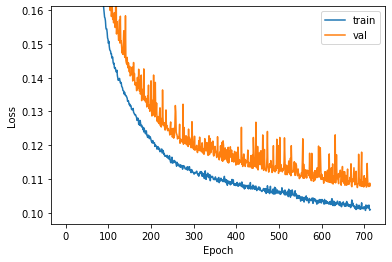

Normalized RMSE: [0.32859781]


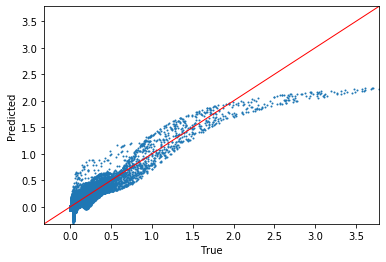

R2: [0.89575561]


In [27]:
# Well, that didn't make much of a difference...but that's okay. 
# We now have a better way to represent our data (fewer inputs)
# Let's make things more complex -- add more nodes!
layers = [16]
activ  = ['tanh']
fname  = 'hidden1_16node_tanh_gaus-shift'

model, val_pred_denorm, rmse_val, r2_val = \
                   TrainValArch(new_inputs_tr_norm,  new_gaus_tr_norm, 
                                new_inputs_val_norm, new_gaus_val_norm,
                                new_gaus_tr_mean,    new_gaus_tr_stdev, 
                                layers, activ, learnrate, 
                                batch_size, epochs, patience, fname)

Weight file does not exist. Training new model.
Train on 350000 samples, validate on 50000 samples
Epoch 1/1000
350000/350000 [==============================] - 1s 4us/step - loss: 0.7715 - val_loss: 0.7104

Epoch 00001: val_loss improved from inf to 0.71039, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 2/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.6271 - val_loss: 0.6165

Epoch 00002: val_loss improved from 0.71039 to 0.61652, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 3/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.5500 - val_loss: 0.5631

Epoch 00003: val_loss improved from 0.61652 to 0.56308, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 4/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.5024 - val_loss: 0.5195

Epoch 00004: val_loss improved from 0.56308


Epoch 00067: val_loss improved from 0.14079 to 0.13947, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 68/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1280 - val_loss: 0.1425

Epoch 00068: val_loss did not improve from 0.13947
Epoch 69/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1270 - val_loss: 0.1392

Epoch 00069: val_loss improved from 0.13947 to 0.13916, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 70/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1262 - val_loss: 0.1399

Epoch 00070: val_loss did not improve from 0.13916
Epoch 71/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1259 - val_loss: 0.1358

Epoch 00071: val_loss improved from 0.13916 to 0.13577, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 72/1000
350000/350000 [==

350000/350000 [==============================] - 1s 2us/step - loss: 0.1056 - val_loss: 0.1132

Epoch 00106: val_loss improved from 0.11448 to 0.11321, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 107/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1049 - val_loss: 0.1125

Epoch 00107: val_loss improved from 0.11321 to 0.11248, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 108/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.1040 - val_loss: 0.1146

Epoch 00108: val_loss did not improve from 0.11248
Epoch 109/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1036 - val_loss: 0.1129

Epoch 00109: val_loss did not improve from 0.11248
Epoch 110/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.1034 - val_loss: 0.1167

Epoch 00110: val_loss did not improve from 0.11248
Epoch 111/1000
350000/3

350000/350000 [==============================] - 1s 3us/step - loss: 0.0912 - val_loss: 0.1025

Epoch 00146: val_loss did not improve from 0.09904
Epoch 147/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0920 - val_loss: 0.0983

Epoch 00147: val_loss improved from 0.09904 to 0.09826, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 148/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0913 - val_loss: 0.0994

Epoch 00148: val_loss did not improve from 0.09826
Epoch 149/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0913 - val_loss: 0.1057

Epoch 00149: val_loss did not improve from 0.09826
Epoch 150/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0905 - val_loss: 0.1000

Epoch 00150: val_loss did not improve from 0.09826
Epoch 151/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0901 - val_loss: 0.0978

Epo

350000/350000 [==============================] - 1s 3us/step - loss: 0.0762 - val_loss: 0.0807

Epoch 00231: val_loss improved from 0.08083 to 0.08074, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 232/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0759 - val_loss: 0.0807

Epoch 00232: val_loss improved from 0.08074 to 0.08069, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 233/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0759 - val_loss: 0.0799

Epoch 00233: val_loss improved from 0.08069 to 0.07993, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 234/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0760 - val_loss: 0.0868

Epoch 00234: val_loss did not improve from 0.07993
Epoch 235/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0750 - v

350000/350000 [==============================] - 1s 3us/step - loss: 0.0645 - val_loss: 0.0686

Epoch 00316: val_loss improved from 0.06948 to 0.06855, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 317/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0651 - val_loss: 0.0699

Epoch 00317: val_loss did not improve from 0.06855
Epoch 318/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0649 - val_loss: 0.0691

Epoch 00318: val_loss did not improve from 0.06855
Epoch 319/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0643 - val_loss: 0.0705

Epoch 00319: val_loss did not improve from 0.06855
Epoch 320/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0653 - val_loss: 0.0714

Epoch 00320: val_loss did not improve from 0.06855
Epoch 321/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0655 - val_loss: 0.0686

Epo


Epoch 00405: val_loss did not improve from 0.06142
Epoch 406/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0578 - val_loss: 0.0618

Epoch 00406: val_loss did not improve from 0.06142
Epoch 407/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0585 - val_loss: 0.0616

Epoch 00407: val_loss did not improve from 0.06142
Epoch 408/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0583 - val_loss: 0.0611

Epoch 00408: val_loss improved from 0.06142 to 0.06107, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 409/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0585 - val_loss: 0.0630

Epoch 00409: val_loss did not improve from 0.06107
Epoch 410/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0584 - val_loss: 0.0614

Epoch 00410: val_loss did not improve from 0.06107
Epoch 411/1000
350000/350000 [=================

350000/350000 [==============================] - 1s 3us/step - loss: 0.0552 - val_loss: 0.0604

Epoch 00452: val_loss did not improve from 0.05942
Epoch 453/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0555 - val_loss: 0.0598

Epoch 00453: val_loss did not improve from 0.05942
Epoch 454/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0565 - val_loss: 0.0599

Epoch 00454: val_loss did not improve from 0.05942
Epoch 455/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0554 - val_loss: 0.0581

Epoch 00455: val_loss improved from 0.05942 to 0.05808, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 456/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0564 - val_loss: 0.0625

Epoch 00456: val_loss did not improve from 0.05808
Epoch 457/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0559 - val_loss: 0.0583

Epo

350000/350000 [==============================] - 1s 3us/step - loss: 0.0526 - val_loss: 0.0557

Epoch 00546: val_loss did not improve from 0.05422
Epoch 547/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0523 - val_loss: 0.0540

Epoch 00547: val_loss improved from 0.05422 to 0.05405, saving model to weights/hidden1_64node_tanh_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 548/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0514 - val_loss: 0.0552

Epoch 00548: val_loss did not improve from 0.05405
Epoch 549/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0526 - val_loss: 0.0563

Epoch 00549: val_loss did not improve from 0.05405
Epoch 550/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0522 - val_loss: 0.0560

Epoch 00550: val_loss did not improve from 0.05405
Epoch 551/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0519 - val_loss: 0.0541

Epo

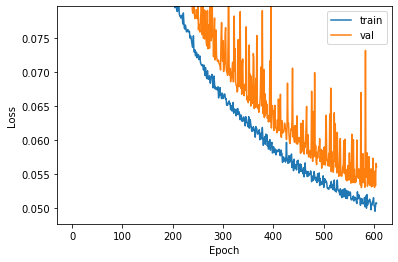

Normalized RMSE: [0.23689685]


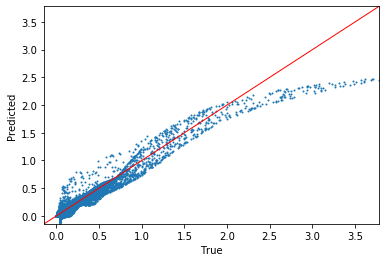

R2: [0.94581963]


In [28]:
# Now that looks a lot better! Still some error, esp. for larger values
# Let's see if we can improve that -- more nodes?
layers = [64]
activ  = ['tanh']
fname  = 'hidden1_64node_tanh_gaus-shift'

model, val_pred_denorm, rmse_val, r2_val = \
                   TrainValArch(new_inputs_tr_norm,  new_gaus_tr_norm, 
                                new_inputs_val_norm, new_gaus_val_norm,
                                new_gaus_tr_mean,    new_gaus_tr_stdev, 
                                layers, activ, learnrate, 
                                batch_size, epochs, patience, fname)

Weight file does not exist. Training new model.
Train on 350000 samples, validate on 50000 samples
Epoch 1/1000
350000/350000 [==============================] - 2s 4us/step - loss: 0.8471 - val_loss: 0.8540

Epoch 00001: val_loss improved from inf to 0.85397, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 2/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.7611 - val_loss: 0.7322

Epoch 00002: val_loss improved from 0.85397 to 0.73219, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 3/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.6531 - val_loss: 0.6532

Epoch 00003: val_loss improved from 0.73219 to 0.65321, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 4/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.5910 - val_loss: 0.6062

Epoch 00004: val_loss 

350000/350000 [==============================] - 1s 3us/step - loss: 0.0386 - val_loss: 0.0428

Epoch 00064: val_loss improved from 0.04369 to 0.04279, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 65/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0377 - val_loss: 0.0419

Epoch 00065: val_loss improved from 0.04279 to 0.04186, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 66/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0370 - val_loss: 0.0412

Epoch 00066: val_loss improved from 0.04186 to 0.04120, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 67/1000
350000/350000 [==============================] - 1s 4us/step - loss: 0.0364 - val_loss: 0.0404

Epoch 00067: val_loss improved from 0.04120 to 0.04043, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoin

350000/350000 [==============================] - 1s 3us/step - loss: 0.0176 - val_loss: 0.0198

Epoch 00098: val_loss did not improve from 0.01974
Epoch 99/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0174 - val_loss: 0.0188

Epoch 00099: val_loss improved from 0.01974 to 0.01882, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 100/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0170 - val_loss: 0.0190

Epoch 00100: val_loss did not improve from 0.01882
Epoch 101/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0168 - val_loss: 0.0185

Epoch 00101: val_loss improved from 0.01882 to 0.01849, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 102/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0166 - val_loss: 0.0194

Epoch 00102: val_loss did not improve from 0.01849
Epoch 103/

350000/350000 [==============================] - 1s 3us/step - loss: 0.0070 - val_loss: 0.0071

Epoch 00171: val_loss improved from 0.00738 to 0.00711, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 172/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0069 - val_loss: 0.0073

Epoch 00172: val_loss did not improve from 0.00711
Epoch 173/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0068 - val_loss: 0.0075

Epoch 00173: val_loss did not improve from 0.00711
Epoch 174/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0069 - val_loss: 0.0070

Epoch 00174: val_loss improved from 0.00711 to 0.00704, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 175/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0069 - val_loss: 0.0076

Epoch 00175: val_loss did not improve from 0.00704
Epoch 176


Epoch 00212: val_loss did not improve from 0.00566
Epoch 213/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0055 - val_loss: 0.0063

Epoch 00213: val_loss did not improve from 0.00566
Epoch 214/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0055 - val_loss: 0.0056

Epoch 00214: val_loss improved from 0.00566 to 0.00562, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 215/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0054 - val_loss: 0.0055

Epoch 00215: val_loss improved from 0.00562 to 0.00551, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 216/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0054 - val_loss: 0.0058

Epoch 00216: val_loss did not improve from 0.00551
Epoch 217/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0054 - val_loss: 0

350000/350000 [==============================] - 1s 3us/step - loss: 0.0046 - val_loss: 0.0051

Epoch 00255: val_loss did not improve from 0.00481
Epoch 256/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0046 - val_loss: 0.0047

Epoch 00256: val_loss improved from 0.00481 to 0.00470, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 257/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0047 - val_loss: 0.0047

Epoch 00257: val_loss improved from 0.00470 to 0.00466, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 258/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0046 - val_loss: 0.0050

Epoch 00258: val_loss did not improve from 0.00466
Epoch 259/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0046 - val_loss: 0.0047

Epoch 00259: val_loss did not improve from 0.00466
Epoch 260


Epoch 00299: val_loss did not improve from 0.00413
Epoch 300/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0040 - val_loss: 0.0044

Epoch 00300: val_loss did not improve from 0.00413
Epoch 301/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0041 - val_loss: 0.0040

Epoch 00301: val_loss improved from 0.00413 to 0.00402, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 302/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0040 - val_loss: 0.0045

Epoch 00302: val_loss did not improve from 0.00402
Epoch 303/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0041 - val_loss: 0.0046

Epoch 00303: val_loss did not improve from 0.00402
Epoch 304/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0040 - val_loss: 0.0042

Epoch 00304: val_loss did not improve from 0.00402
Epoch 305/1000
350000/350000 [==========

Epoch 345/1000
350000/350000 [==============================] - 1s 2us/step - loss: 0.0036 - val_loss: 0.0037

Epoch 00345: val_loss did not improve from 0.00355
Epoch 346/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0036 - val_loss: 0.0036

Epoch 00346: val_loss did not improve from 0.00355
Epoch 347/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0036 - val_loss: 0.0040

Epoch 00347: val_loss did not improve from 0.00355
Epoch 348/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0035 - val_loss: 0.0042

Epoch 00348: val_loss did not improve from 0.00355
Epoch 349/1000
350000/350000 [==============================] - 1s 4us/step - loss: 0.0036 - val_loss: 0.0038

Epoch 00349: val_loss did not improve from 0.00355
Epoch 350/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0035 - val_loss: 0.0036

Epoch 00350: val_loss did not improve from 0.00355
Epoch 351/1000
350000/350000


Epoch 00435: val_loss did not improve from 0.00295
Epoch 436/1000
350000/350000 [==============================] - 1s 4us/step - loss: 0.0030 - val_loss: 0.0030

Epoch 00436: val_loss did not improve from 0.00295
Epoch 437/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0031 - val_loss: 0.0030

Epoch 00437: val_loss did not improve from 0.00295
Epoch 438/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0031 - val_loss: 0.0040

Epoch 00438: val_loss did not improve from 0.00295
Epoch 439/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0030 - val_loss: 0.0030

Epoch 00439: val_loss did not improve from 0.00295
Epoch 440/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0030 - val_loss: 0.0038

Epoch 00440: val_loss did not improve from 0.00295
Epoch 441/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0030 - val_loss: 0.0034

Epoch 00441: val_loss did n

350000/350000 [==============================] - 1s 3us/step - loss: 0.0026 - val_loss: 0.0027

Epoch 00529: val_loss did not improve from 0.00252
Epoch 530/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0026 - val_loss: 0.0027

Epoch 00530: val_loss did not improve from 0.00252
Epoch 531/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0026 - val_loss: 0.0026

Epoch 00531: val_loss did not improve from 0.00252
Epoch 532/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0026 - val_loss: 0.0026

Epoch 00532: val_loss did not improve from 0.00252
Epoch 533/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0026 - val_loss: 0.0028

Epoch 00533: val_loss did not improve from 0.00252
Epoch 534/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0026 - val_loss: 0.0025

Epoch 00534: val_loss improved from 0.00252 to 0.00249, saving model to weights/hidden2_16-16n

350000/350000 [==============================] - 1s 3us/step - loss: 0.0024 - val_loss: 0.0024

Epoch 00577: val_loss did not improve from 0.00228
Epoch 578/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0024 - val_loss: 0.0024

Epoch 00578: val_loss did not improve from 0.00228
Epoch 579/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0023 - val_loss: 0.0024

Epoch 00579: val_loss did not improve from 0.00228
Epoch 580/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0023 - val_loss: 0.0026

Epoch 00580: val_loss did not improve from 0.00228
Epoch 581/1000
350000/350000 [==============================] - 1s 4us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00581: val_loss did not improve from 0.00228
Epoch 582/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0023 - val_loss: 0.0023

Epoch 00582: val_loss improved from 0.00228 to 0.00227, saving model to weights/hidden2_16-16n

350000/350000 [==============================] - 1s 4us/step - loss: 0.0022 - val_loss: 0.0021

Epoch 00623: val_loss improved from 0.00212 to 0.00209, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 624/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0021 - val_loss: 0.0021

Epoch 00624: val_loss did not improve from 0.00209
Epoch 625/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0021 - val_loss: 0.0024

Epoch 00625: val_loss did not improve from 0.00209
Epoch 626/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0022 - val_loss: 0.0023

Epoch 00626: val_loss did not improve from 0.00209
Epoch 627/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0022 - val_loss: 0.0024

Epoch 00627: val_loss did not improve from 0.00209
Epoch 628/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0022 - val_loss: 0.00

350000/350000 [==============================] - 1s 3us/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00669: val_loss improved from 0.00195 to 0.00193, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 670/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0020 - val_loss: 0.0023

Epoch 00670: val_loss did not improve from 0.00193
Epoch 671/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00671: val_loss improved from 0.00193 to 0.00192, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 672/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0020 - val_loss: 0.0021

Epoch 00672: val_loss did not improve from 0.00192
Epoch 673/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0019 - val_loss: 0.0019

Epoch 00673: val_loss did not improve from 0.00192
Epoch 674

350000/350000 [==============================] - 1s 3us/step - loss: 0.0018 - val_loss: 0.0022

Epoch 00715: val_loss did not improve from 0.00181
Epoch 716/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0018 - val_loss: 0.0018

Epoch 00716: val_loss improved from 0.00181 to 0.00180, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 717/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0018 - val_loss: 0.0020

Epoch 00717: val_loss did not improve from 0.00180
Epoch 718/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0018 - val_loss: 0.0018

Epoch 00718: val_loss did not improve from 0.00180
Epoch 719/1000
350000/350000 [==============================] - 1s 4us/step - loss: 0.0018 - val_loss: 0.0018

Epoch 00719: val_loss did not improve from 0.00180
Epoch 720/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0019 - val_loss: 0.00

350000/350000 [==============================] - 1s 3us/step - loss: 0.0017 - val_loss: 0.0017

Epoch 00762: val_loss did not improve from 0.00163
Epoch 763/1000
350000/350000 [==============================] - 1s 4us/step - loss: 0.0017 - val_loss: 0.0016

Epoch 00763: val_loss did not improve from 0.00163
Epoch 764/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0017 - val_loss: 0.0020

Epoch 00764: val_loss did not improve from 0.00163
Epoch 765/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0017 - val_loss: 0.0016

Epoch 00765: val_loss did not improve from 0.00163
Epoch 766/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0017 - val_loss: 0.0019

Epoch 00766: val_loss did not improve from 0.00163
Epoch 767/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0017 - val_loss: 0.0016

Epoch 00767: val_loss did not improve from 0.00163
Epoch 768/1000
350000/350000 [=============


Epoch 00855: val_loss did not improve from 0.00141
Epoch 856/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0017 - val_loss: 0.0014

Epoch 00856: val_loss did not improve from 0.00141
Epoch 857/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0015 - val_loss: 0.0015

Epoch 00857: val_loss did not improve from 0.00141
Epoch 858/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0015 - val_loss: 0.0014

Epoch 00858: val_loss did not improve from 0.00141
Epoch 859/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0014 - val_loss: 0.0015

Epoch 00859: val_loss did not improve from 0.00141
Epoch 860/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0015 - val_loss: 0.0014

Epoch 00860: val_loss did not improve from 0.00141
Epoch 861/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0014 - val_loss: 0.0014

Epoch 00861: val_loss impro

350000/350000 [==============================] - 1s 3us/step - loss: 0.0014 - val_loss: 0.0015

Epoch 00904: val_loss did not improve from 0.00131
Epoch 905/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0014 - val_loss: 0.0014

Epoch 00905: val_loss did not improve from 0.00131
Epoch 906/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00906: val_loss did not improve from 0.00131
Epoch 907/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00907: val_loss did not improve from 0.00131
Epoch 908/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0015 - val_loss: 0.0020

Epoch 00908: val_loss did not improve from 0.00131
Epoch 909/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0014 - val_loss: 0.0014

Epoch 00909: val_loss did not improve from 0.00131
Epoch 910/1000
350000/350000 [=============

350000/350000 [==============================] - 1s 3us/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00997: val_loss did not improve from 0.00114
Epoch 998/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00998: val_loss did not improve from 0.00114
Epoch 999/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0013 - val_loss: 0.0012

Epoch 00999: val_loss did not improve from 0.00114
Epoch 1000/1000
350000/350000 [==============================] - 1s 3us/step - loss: 0.0012 - val_loss: 0.0011

Epoch 01000: val_loss improved from 0.00114 to 0.00114, saving model to weights/hidden2_16-16node_tanh-sig_gaus-shift_checkpoint_weights_mse_loss.h5


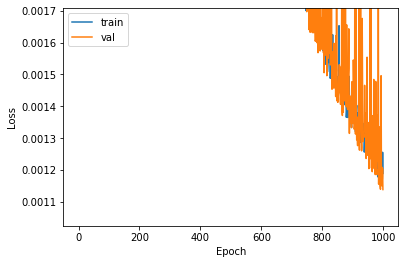

Normalized RMSE: [0.03374197]


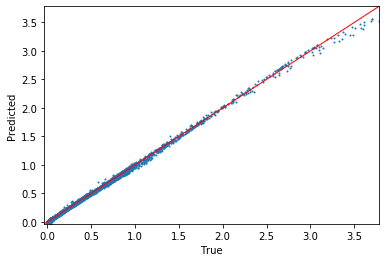

R2: [0.99890083]


In [29]:
# Small improvement, but still not as good as we would like...
# Let's try adding a second hidden layer! 
# We'll use a sigmoid activation function
# This smoothly spans [0, 1], which is perfect for probability functions
#  Note: For most problems, there are better choices for activation functions!
learnrate = 1e-3
layers    = [16, 16]
activ     = ['tanh', 'sigmoid']
fname     = 'hidden2_16-16node_tanh-sig_gaus-shift'

model, val_pred_denorm, rmse_val, r2_val = \
                   TrainValArch(new_inputs_tr_norm,  new_gaus_tr_norm, 
                                new_inputs_val_norm, new_gaus_val_norm,
                                new_gaus_tr_mean,    new_gaus_tr_stdev, 
                                layers, activ, learnrate, 
                                batch_size, epochs, patience, fname)

Weight file does not exist. Training new model.
Train on 350000 samples, validate on 50000 samples
Epoch 1/1000
350000/350000 [==============================] - 2s 7us/step - loss: 0.7990 - val_loss: 0.6810

Epoch 00001: val_loss improved from inf to 0.68104, saving model to weights/hidden3_64-64-64node_tanh-sig-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 2/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.5671 - val_loss: 0.5566

Epoch 00002: val_loss improved from 0.68104 to 0.55660, saving model to weights/hidden3_64-64-64node_tanh-sig-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 3/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.4946 - val_loss: 0.5056

Epoch 00003: val_loss improved from 0.55660 to 0.50561, saving model to weights/hidden3_64-64-64node_tanh-sig-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 4/1000
350000/350000 [==============================] - 2s 7us/step - loss: 0.4557 - val_loss: 0.4735

E

350000/350000 [==============================] - 2s 5us/step - loss: 0.0022 - val_loss: 0.0015

Epoch 00034: val_loss improved from 0.00243 to 0.00152, saving model to weights/hidden3_64-64-64node_tanh-sig-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 35/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0020 - val_loss: 0.0020

Epoch 00035: val_loss did not improve from 0.00152
Epoch 36/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0022 - val_loss: 0.0016

Epoch 00036: val_loss did not improve from 0.00152
Epoch 37/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0017 - val_loss: 0.0015

Epoch 00037: val_loss improved from 0.00152 to 0.00149, saving model to weights/hidden3_64-64-64node_tanh-sig-sig_gaus-shift_checkpoint_weights_mse_loss.h5
Epoch 38/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0025 - val_loss: 0.0031

Epoch 00038: val_loss did not improve from 0.00149

350000/350000 [==============================] - 2s 6us/step - loss: 0.0014 - val_loss: 3.0070e-04

Epoch 00077: val_loss did not improve from 0.00030
Epoch 78/1000
350000/350000 [==============================] - 2s 6us/step - loss: 6.5941e-04 - val_loss: 0.0012

Epoch 00078: val_loss did not improve from 0.00030
Epoch 79/1000
350000/350000 [==============================] - 2s 5us/step - loss: 7.7714e-04 - val_loss: 4.0960e-04

Epoch 00079: val_loss did not improve from 0.00030
Epoch 80/1000
350000/350000 [==============================] - 2s 6us/step - loss: 5.1327e-04 - val_loss: 0.0049

Epoch 00080: val_loss did not improve from 0.00030
Epoch 81/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0014 - val_loss: 0.0018

Epoch 00081: val_loss did not improve from 0.00030
Epoch 82/1000
350000/350000 [==============================] - 2s 5us/step - loss: 9.3237e-04 - val_loss: 9.3115e-04

Epoch 00082: val_loss did not improve from 0.00030
Epoch 83/1000
350000

350000/350000 [==============================] - 2s 6us/step - loss: 3.5249e-04 - val_loss: 5.7081e-04

Epoch 00123: val_loss did not improve from 0.00012
Epoch 124/1000
350000/350000 [==============================] - 2s 6us/step - loss: 3.0715e-04 - val_loss: 4.0693e-04

Epoch 00124: val_loss did not improve from 0.00012
Epoch 125/1000
350000/350000 [==============================] - 2s 5us/step - loss: 2.6423e-04 - val_loss: 2.8435e-04

Epoch 00125: val_loss did not improve from 0.00012
Epoch 126/1000
350000/350000 [==============================] - 2s 6us/step - loss: 2.1114e-04 - val_loss: 1.2127e-04

Epoch 00126: val_loss did not improve from 0.00012
Epoch 127/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0021 - val_loss: 1.3043e-04

Epoch 00127: val_loss did not improve from 0.00012
Epoch 128/1000
350000/350000 [==============================] - 2s 6us/step - loss: 3.0516e-04 - val_loss: 4.9450e-04

Epoch 00128: val_loss did not improve from 0.00012

350000/350000 [==============================] - 2s 6us/step - loss: 1.6973e-04 - val_loss: 8.2523e-05

Epoch 00169: val_loss did not improve from 0.00008
Epoch 170/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0010 - val_loss: 0.0018

Epoch 00170: val_loss did not improve from 0.00008
Epoch 171/1000
350000/350000 [==============================] - 2s 6us/step - loss: 7.0693e-04 - val_loss: 1.0156e-04

Epoch 00171: val_loss did not improve from 0.00008
Epoch 172/1000
350000/350000 [==============================] - 2s 6us/step - loss: 1.8794e-04 - val_loss: 1.3624e-04

Epoch 00172: val_loss did not improve from 0.00008
Epoch 173/1000
350000/350000 [==============================] - 2s 6us/step - loss: 5.2675e-04 - val_loss: 0.0021

Epoch 00173: val_loss did not improve from 0.00008
Epoch 174/1000
350000/350000 [==============================] - 2s 5us/step - loss: 3.0873e-04 - val_loss: 7.8825e-05

Epoch 00174: val_loss did not improve from 0.00008
Epoch 1

350000/350000 [==============================] - 2s 6us/step - loss: 2.1912e-04 - val_loss: 1.0697e-04

Epoch 00216: val_loss did not improve from 0.00006
Epoch 217/1000
350000/350000 [==============================] - 2s 5us/step - loss: 4.3477e-04 - val_loss: 9.4107e-05

Epoch 00217: val_loss did not improve from 0.00006
Epoch 218/1000
350000/350000 [==============================] - 2s 6us/step - loss: 5.2142e-04 - val_loss: 1.3412e-04

Epoch 00218: val_loss did not improve from 0.00006
Epoch 219/1000
350000/350000 [==============================] - 2s 5us/step - loss: 2.8341e-04 - val_loss: 3.4203e-04

Epoch 00219: val_loss did not improve from 0.00006
Epoch 220/1000
350000/350000 [==============================] - 2s 5us/step - loss: 2.4620e-04 - val_loss: 1.6386e-04

Epoch 00220: val_loss did not improve from 0.00006
Epoch 221/1000
350000/350000 [==============================] - 2s 6us/step - loss: 1.8645e-04 - val_loss: 5.2275e-05

Epoch 00221: val_loss improved from 0.00006 to

350000/350000 [==============================] - 2s 6us/step - loss: 1.7109e-04 - val_loss: 6.5045e-05

Epoch 00262: val_loss did not improve from 0.00004
Epoch 263/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0012 - val_loss: 0.0102

Epoch 00263: val_loss did not improve from 0.00004
Epoch 264/1000
350000/350000 [==============================] - 2s 6us/step - loss: 5.7679e-04 - val_loss: 0.0015

Epoch 00264: val_loss did not improve from 0.00004
Epoch 265/1000
350000/350000 [==============================] - 2s 6us/step - loss: 3.2281e-04 - val_loss: 8.1590e-05

Epoch 00265: val_loss did not improve from 0.00004
Epoch 266/1000
350000/350000 [==============================] - 2s 6us/step - loss: 2.8627e-04 - val_loss: 5.5788e-05

Epoch 00266: val_loss did not improve from 0.00004
Epoch 267/1000
350000/350000 [==============================] - 2s 6us/step - loss: 2.2351e-04 - val_loss: 5.1932e-05

Epoch 00267: val_loss did not improve from 0.00004
Epoch 2


Epoch 00308: val_loss did not improve from 0.00004
Epoch 309/1000
350000/350000 [==============================] - 2s 6us/step - loss: 2.2574e-04 - val_loss: 5.8363e-05

Epoch 00309: val_loss did not improve from 0.00004
Epoch 310/1000
350000/350000 [==============================] - 2s 6us/step - loss: 5.9659e-04 - val_loss: 4.6307e-04

Epoch 00310: val_loss did not improve from 0.00004
Epoch 311/1000
350000/350000 [==============================] - 2s 6us/step - loss: 8.7513e-04 - val_loss: 3.8446e-04

Epoch 00311: val_loss did not improve from 0.00004
Epoch 312/1000
350000/350000 [==============================] - 2s 5us/step - loss: 3.1476e-04 - val_loss: 1.1393e-04

Epoch 00312: val_loss did not improve from 0.00004
Epoch 313/1000
350000/350000 [==============================] - 2s 5us/step - loss: 1.4831e-04 - val_loss: 1.1428e-04

Epoch 00313: val_loss did not improve from 0.00004
Epoch 314/1000
350000/350000 [==============================] - 2s 6us/step - loss: 0.0030 - val_l

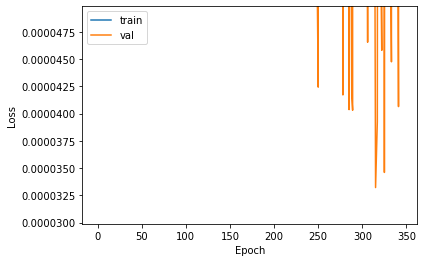

Normalized RMSE: [0.00781032]


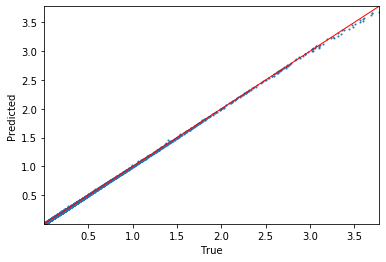

R2: [0.99994111]


In [36]:
# This looks good -- R^2 ~ 0.99!
# Let's see if we can get R^2 above 0.999
# Let's try adding more nodes and another layer
layers = [64, 64, 64]
activ  = ['tanh', 'sigmoid', 'sigmoid']
fname  = 'hidden3_64-64-64node_tanh-sig-sig_gaus-shift'

model, val_pred_denorm, rmse_val, r2_val = \
                   TrainValArch(new_inputs_tr_norm,  new_gaus_tr_norm, 
                                new_inputs_val_norm, new_gaus_val_norm,
                                new_gaus_tr_mean,    new_gaus_tr_stdev, 
                                layers, activ, learnrate, 
                                batch_size, epochs, patience, fname)

Normalized RMSE: [0.00728031]


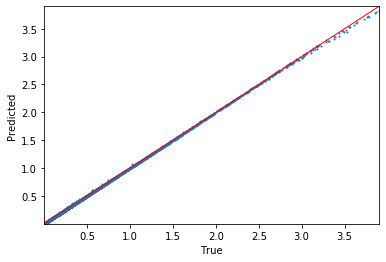

R2: [0.99994755]


In [37]:
# Now that we have a good model, let's continue...
### Step 5: Apply model to the test set
te_pred_denorm, rmse_te, r2_te = TestModel(model, 
                                           new_inputs_te_norm, 
                                           new_gaus_te_norm, 
                                           new_gaus_tr_mean, 
                                           new_gaus_tr_stdev, 
                                           batch_size, 
                                           fname)

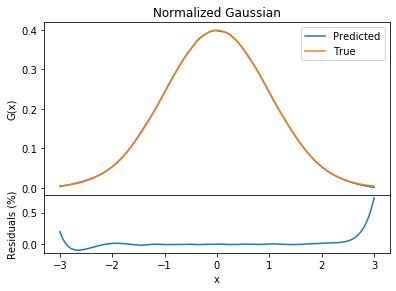

In [38]:
# The model generalized well!
# (Of course, we expect this since the data was generated in the same manner)

# Let's draw some Gaussians!
# First: a normalized Gaussian over [-3, 3]
ng_x   = np.linspace(-3, 3, 1001)
ng_mu  = np.zeros(1001)
ng_sig = np.ones (1001)

# Analytical Gaussian corresponding to these inputs
normgaus_true = gaussian(ng_x) # Note that function defaults to mu=0, sigma=1

# Normalize inputs and predict
ng_inp         = np.vstack([ng_x-ng_mu, ng_sig]).T
ng_inp         = (ng_inp - new_inputs_tr_mean) / new_inputs_tr_stdev
normgaus_pred  = model.predict(ng_inp)[:,0] #2D-->1D
# Denormalize predictions
normgaus_pred *= new_gaus_tr_stdev 
normgaus_pred += new_gaus_tr_mean

# Plot it
fig1   = plt.figure(1)
frame1 = fig1.add_axes((.1, .3, .8, .6))
plt.plot(ng_x, normgaus_pred, label='Predicted')
plt.plot(ng_x, normgaus_true, label='True')
plt.title("Normalized Gaussian")
plt.ylabel('G(x)')
plt.legend(loc='best')
frame1.set_xticklabels([])
frame2 = fig1.add_axes((.1, .1, .8, .2))
plt.plot(ng_x, (normgaus_true - normgaus_pred) / normgaus_true)
plt.ylabel('Residuals (%)')
plt.xlabel('x')
plt.savefig('plots/'+fname+'_test_normgaus.png', bbox_inches='tight')
plt.show()

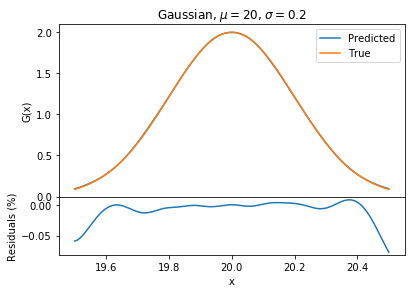

In [39]:
# Looks pretty good
# Let's try 2 more cases and see how it does.
# Case 1: small sigma case, with mu!=0
sg_x   = np.linspace(19.5, 20.5, 1001)
sg_mu  = np.zeros(1001) + 20
sg_sig = np.ones (1001) * 0.2

# Analytical Gaussian corresponding to these inputs
smallgaus_true = gaussian(sg_x, sg_mu, sg_sig)

# Normalize inputs and predict
sg_inp          = np.vstack([sg_x-sg_mu, sg_sig]).T
sg_inp          = (sg_inp - new_inputs_tr_mean) / new_inputs_tr_stdev
smallgaus_pred  = model.predict(sg_inp)[:,0] #2D-->1D
# Denormalize predictions
smallgaus_pred *= new_gaus_tr_stdev 
smallgaus_pred += new_gaus_tr_mean


# Plot it
fig1   = plt.figure(1)
frame1 = fig1.add_axes((.1, .3, .8, .6))
plt.plot(sg_x, smallgaus_pred, label='Predicted')
plt.plot(sg_x, smallgaus_true, label='True')
plt.title("Gaussian, $\mu = 20$, $\sigma = 0.2$")
plt.ylabel('G(x)')
plt.legend(loc='best')
frame1.set_xticklabels([])
frame2 = fig1.add_axes((.1, .1, .8, .2))
plt.plot(sg_x, (smallgaus_true - smallgaus_pred) / smallgaus_true)
plt.ylabel('Residuals (%)')
plt.xlabel('x')
plt.savefig('plots/'+fname+'_test_smallgaus.png', bbox_inches='tight')
plt.show()

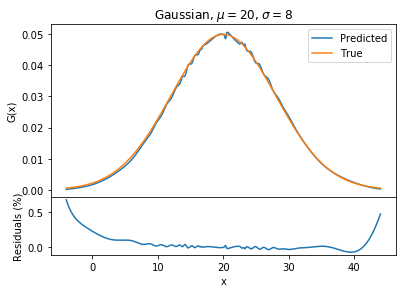

In [40]:
# Looks pretty good

# Case 2: let's try something with more uncertainty
wg_x   = np.linspace(-4, 44, 1001)
wg_mu  = np.zeros(1001) + 20
wg_sig = np.ones (1001) * 8

# Analytical Gaussian corresponding to these inputs
widegaus_true = gaussian(wg_x, wg_mu, wg_sig)

# Normalize inputs and predict
wg_inp         = np.vstack([wg_x-wg_mu, wg_sig]).T
wg_inp         = (wg_inp - new_inputs_tr_mean) / new_inputs_tr_stdev
widegaus_pred  = model.predict(wg_inp)[:,0] #2D-->1D
# Denormalize predictions
widegaus_pred *= new_gaus_tr_stdev 
widegaus_pred += new_gaus_tr_mean


# Plot it
fig1   = plt.figure(1)
frame1 = fig1.add_axes((.1, .3, .8, .6))
plt.plot(wg_x, widegaus_pred, label='Predicted')
plt.plot(wg_x, widegaus_true, label='True')
plt.title("Gaussian, $\mu = 20$, $\sigma = 8$")
plt.ylabel('G(x)')
plt.legend(loc='best')
frame1.set_xticklabels([])
frame2 = fig1.add_axes((.1, .1, .8, .2))
plt.plot(wg_x, (widegaus_true - widegaus_pred) / widegaus_true)
plt.ylabel('Residuals (%)')
plt.xlabel('x')
plt.savefig('plots/'+fname+'_test_widegaus.png', bbox_inches='tight')
plt.show()

In [41]:
# Not so good. This goes to show that even if the model does well in general, 
# you shouldn't trust it in all cases. ML is only as good as the data/model.
# How can we improve the performance?
# We can modify the model architecture and/or use more data